# This script analyses the NWB files

In [6]:
# import the libraries

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import NullFormatter
from matplotlib.colors import ListedColormap

import numpy as np
from scipy import stats
import csv

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer 
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold
from time import time

from sklearn import clone
from sklearn import metrics
from sklearn.cluster import KMeans
from numpy import genfromtxt

# Plotting options
%matplotlib inline

# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    
matplotlib.rcParams.update({'font.size': 15})


In [7]:
# Change parameters of the Figure size for sure

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    


# Load features and labels

In [61]:
# load the feature matrix
all_features_matrix = genfromtxt('ALL_EPHYS_FEATURES_EXP_hipp_GC.csv', delimiter=' ')

# load the cell_type names
with open("ALL_EPHYS_EXP_CELL_CELL_NAMES_hipp_GC.csv", "r") as csvfile:
    cell_names = list(csv.reader(csvfile, delimiter=","))[0]

# load patient labels
with open("ALL_EPHYS_EXP_PATIENT_LABELS_hipp_GC.csv", "r") as csvfile:
    patient_label = list(csv.reader(csvfile, delimiter=","))[0]
    
patient_label=np.array(list(map(float, patient_label))).astype(int)

# load the cell_type names
with open("ALL_EPHYS_EXP_FEATURE_NAMES_hipp_GC.csv", "r") as csvfile:
    feature_names = list(csv.reader(csvfile, delimiter=","))[0]

# Find indexes of the model cells

In [63]:
# find cell names which are specific for 24 cells for WG1 and WG4

wg1_cells_best=['1706014110201.nwb','1706014110202.nwb','1706014110502.nwb','1706014110703.nwb','1706014110704.nwb','1706015210802.nwb','1706015210901.nwb','1706015210902.nwb','1706015210904.nwb','1706015210906.nwb','1706015210907.nwb','1706015211001.nwb']
wg4_cells_best=['1606013050102.nwb','1606013050103.nwb','1606013050301.nwb','1606013050501.nwb','1606013050504.nwb','1706012210307.nwb','1706012210308.nwb','1706012210403.nwb','1706012210501.nwb','1706012210502.nwb','1706012211201.nwb','1706012211205.nwb']

# find the indexes of the best cells

both = set(wg1_cells_best).intersection(cell_names)
wg1_best_idx = [cell_names.index(x) for x in both]
wg1_best_idx=np.array(wg1_best_idx)
print('Indexes of wg1 model cells')
print(wg1_best_idx)


both = set(wg4_cells_best).intersection(cell_names)
wg4_best_idx = [cell_names.index(x) for x in both]
wg4_best_idx=np.array(wg4_best_idx)
print('Indexes of wg4 model cells')
print(wg4_best_idx)


Indexes of wg1 model cells
[32 31 28 48 49 50 35 52 46 51 36 56]
Indexes of wg4 model cells
[ 6 16 25  5 23  2  7  4 15 13 18]


# Remove all rows that have more than 2 NaNs

Resulting matrix shape
(116, 32)


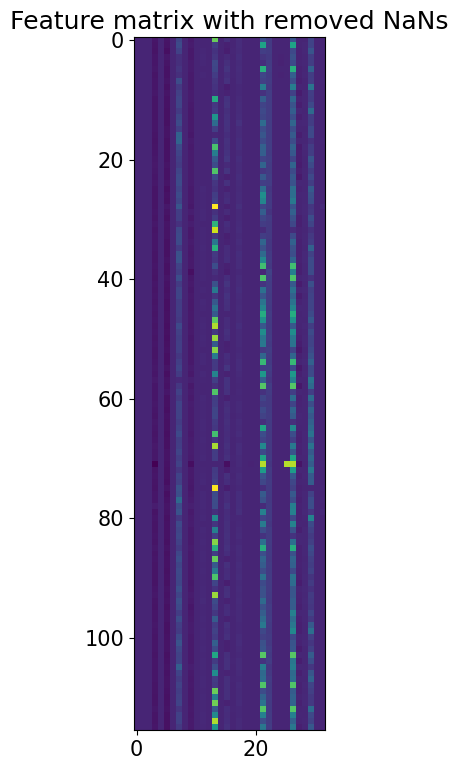

In [64]:
# remove all rows that have more than 5 NaNs

n_nan=np.zeros(len(all_features_matrix))

for i in np.arange(len(all_features_matrix)):
    # count the number of nans
    n_nan[i] = len(np.argwhere(np.isnan(all_features_matrix[i,:])))
    

# set up a threshold for the nan numbers
nan_thr=2
all_features_matrix_no_nan=all_features_matrix[np.where(n_nan<nan_thr)[0]]

plt.imshow(all_features_matrix_no_nan)
plt.title('Feature matrix with removed NaNs')
print('Resulting matrix shape')
print(all_features_matrix_no_nan.shape)

# Impute missing values using medians

Data length
116
Resulting matrix shape
(116, 32)


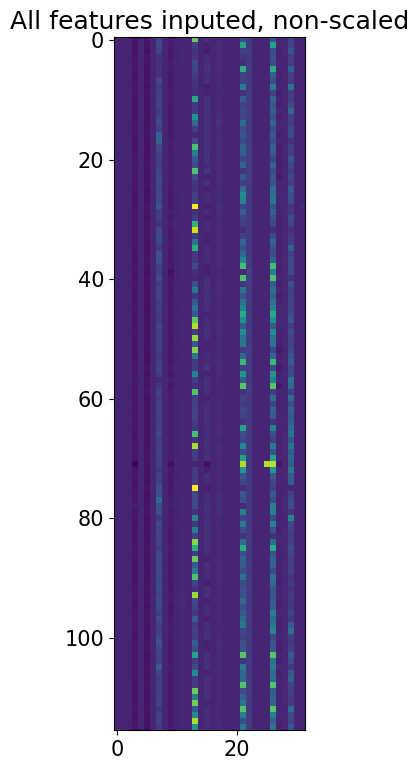

In [66]:
# Remove the NaNs from columns by replacing with the mean

# impute all NaNs in the array and replace with the mean
imp = SimpleImputer(missing_values=np.nan, strategy='median')
# imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(all_features_matrix_no_nan)

# replace all NaNs
all_features_new=imp.transform(all_features_matrix_no_nan)

plt.imshow(all_features_new)
plt.title('All features inputed, non-scaled')
print('Data length')
print(len(all_features_new))
print('Resulting matrix shape')
print(all_features_matrix_no_nan.shape)

# Scale features of the feature matrix

Data length
116


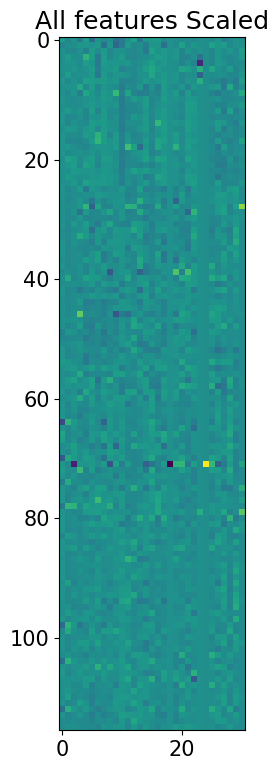

In [67]:
# Normalise all columns of the array
all_features_new_scaled = preprocessing.scale(all_features_new[:,1:])

# show the normalised data
plt.imshow(all_features_new_scaled)
plt.title('All features Scaled')

# show the length
print('Data length')
print(len(all_features_new_scaled))

### Create cell type label

In [68]:

cell_type = all_features_new[:,0]
print('Wyler grade in numbers')
print(cell_type)


Wyler grade in numbers
[1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4.]


### Determine the number of features

In [69]:

n_features = len(all_features_new[0,:-1])
print('Number of features')
print(n_features)


Number of features
31


# Predict the class of H18.06.368: WG1 vs WG4

In [71]:
print('These are patient labels')
print(patient_label)
print('Indexes of cells from 6 patients only')
six_cases_idx=np.where(patient_label<7)[0]
print(six_cases_idx)


These are patient labels
[1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 8 8 8 8 8 8 8 8]
Indexes of cells from 6 patients only
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]


Data length of 6 cases
86


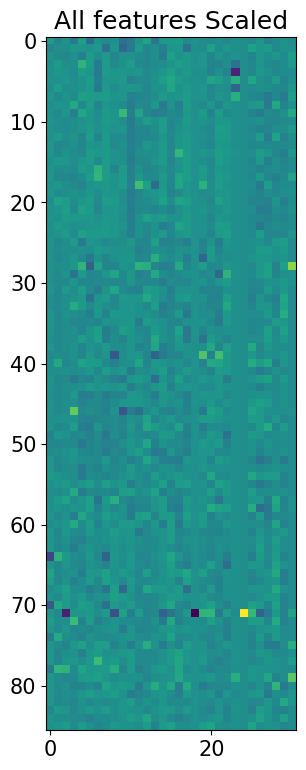

In [72]:
# Normalise all columns of the array - prepare the dataset for smaller size

all_features_new_scaled_6cases = all_features_new_scaled[six_cases_idx,:]

# show the normalised data
plt.imshow(all_features_new_scaled_6cases)
plt.title('All features Scaled')

# show the length
print('Data length of 6 cases')
print(len(all_features_new_scaled_6cases))

In [73]:
# define the cell type label for 6 cases

cell_type_6cases = all_features_new[six_cases_idx,0]
print('Cell types in numbers')
print(cell_type_6cases)
print('Length')
print(len(cell_type_6cases))


Cell types in numbers
[1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 1. 1. 1. 1.]
Length
86


# Create the classifier based on 6 cases only

In [97]:

# the function to predict the WG of the 7th patient based on 6 patients
# returns the probability to be WG1 for the particular patient
# This function trains the random forest classifier based on 6 cases and predicts the 7th one


def check_the_case(case_name,case_number,patient_label,all_features_new_scaled):

    # exclude the 8th case
    patient_label_6=patient_label[np.where(patient_label<8)[0]]

    six_cases_idx=np.where(patient_label_6!=case_number)[0]
    current_case_idx=np.where(patient_label_6==case_number)[0]

    all_features_new_scaled_6cases = all_features_new_scaled[six_cases_idx,:]

    # define the cell type label for 6 cases
    cell_type_6cases = all_features_new[six_cases_idx,0]
#    cell_type_6cases = cell_type_14[six_cases_idx]
    
    # print the number of cells per case
    print('Number of cells ' + 'in ' + case_name)
    print(len(current_case_idx))


    # process the cell type: WG1TS -> WG1 conversion
    global cell_type_14

    cell_type_14=np.array(cell_type_6cases)

    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                min_impurity_decrease=0.0, 
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
                oob_score=True, random_state=0, verbose=0, warm_start=False)

    #RandomForestClassifier(max_depth=None, random_state=0)
    clf.fit(all_features_new_scaled_6cases, cell_type_14)

    # get the scores of the trees and pring them
    scores = clf.score(all_features_new_scaled_6cases, cell_type_14)
    print('Random forest classification score: ' + str(scores))


    oob_error = clf.oob_score_
    print('\n')
    print('Random forest oob classification performance: ' + str(oob_error))

    print('2 classes')
    feature_importance=clf.feature_importances_

    plt.bar(np.arange(0,n_features,1), feature_importance)


    plt.title('Random forest feature importance based on GCs')
    plt.xlabel('Feature number')
    plt.ylabel('Feature weight')


    seven_case_idx=np.where(patient_label_6==case_number)[0]


    seven_case_data=all_features_new_scaled[seven_case_idx,:]

    result=clf.predict(seven_case_data)

    n_wg1=len(np.where(result == 1)[0])
    n_wg4=len(np.where(result == 4)[0])
    
    # probability of WG1 case
    prob=float(n_wg1)/float((n_wg1+n_wg4))
    
    if prob<0.5:
        print('Probaility that ' + str(case_name) + ' cells is WG4')
        print(1-prob)
    elif prob>=0.5:
        print('Probaility that ' + str(case_name) + ' cells is WG1')
        print(prob)
    
    return float(n_wg1)/float((n_wg1+n_wg4))


# H16.06.008 (WG1)

Number of cells in H16.06.008
2
Random forest classification score: 1.0


Random forest oob classification performance: 0.7818181818181819
2 classes
Probaility that H16.06.008 cells is WG1
0.5


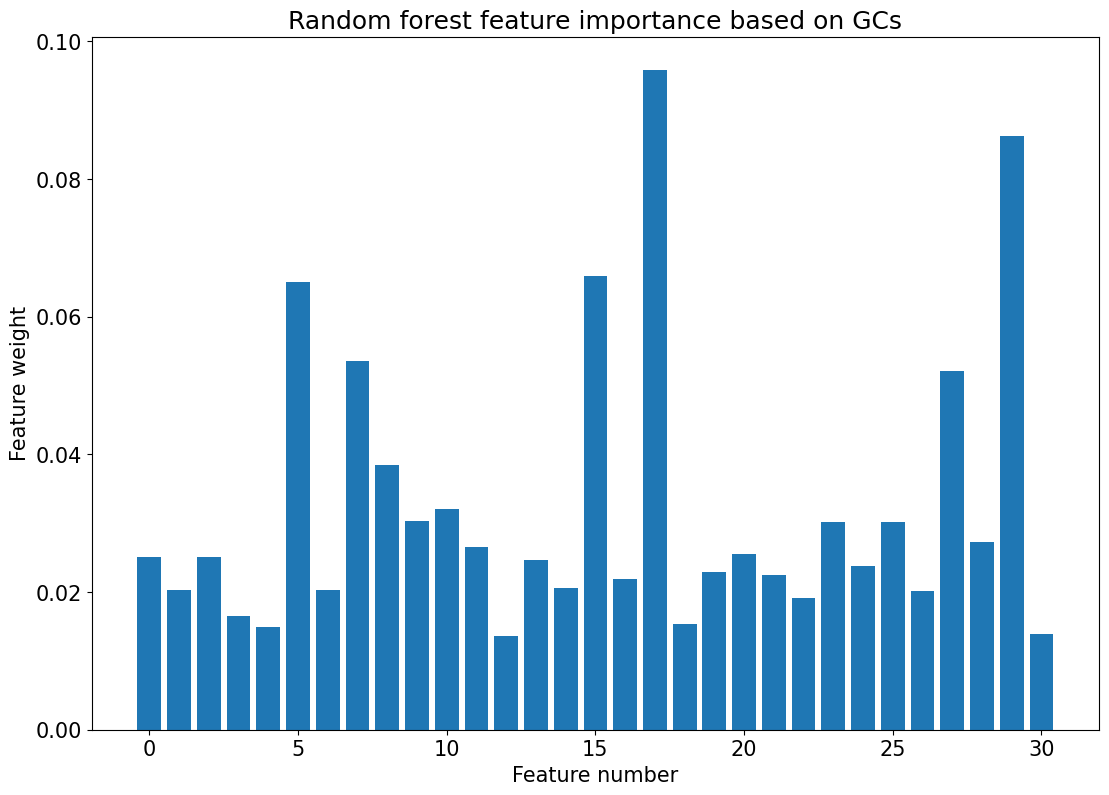

In [98]:
case_name='H16.06.008'
case_number=1

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H16.06.013 (WG4)

Number of cells in H16.06.013
6
Random forest classification score: 1.0


Random forest oob classification performance: 0.7830188679245284
2 classes
Probaility that H16.06.013 cells is WG4
1.0


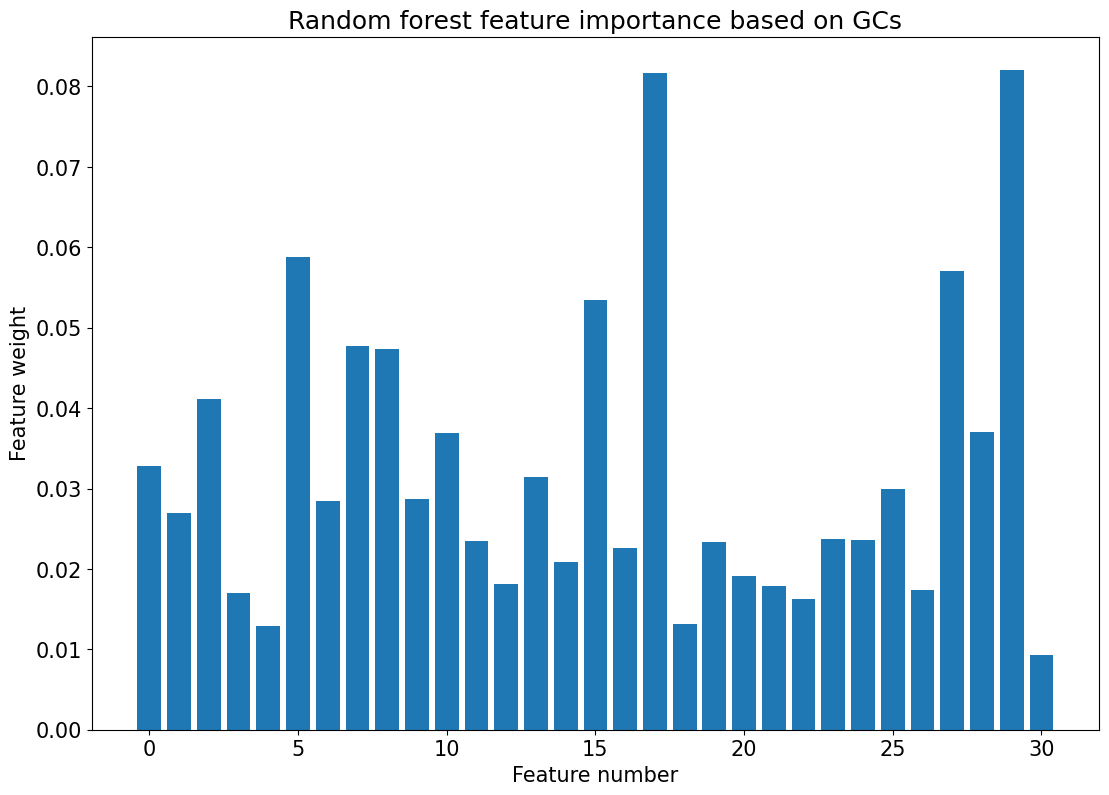

In [81]:
case_name='H16.06.013'
case_number=2

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H17.06.012 (WG3)

Number of cells in H17.06.012
18
Random forest classification score: 1.0


Random forest oob classification performance: 0.8191489361702128
2 classes
Probaility that H17.06.012 cells is WG1
0.9444444444444444


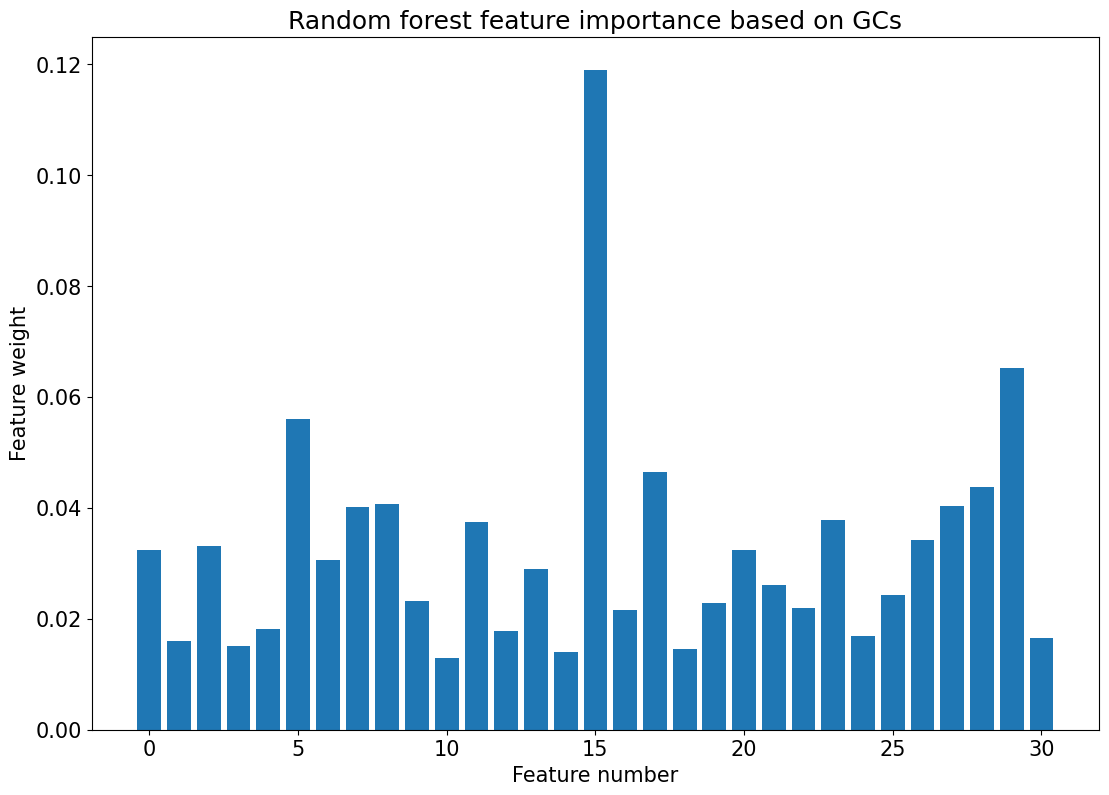

In [82]:
case_name='H17.06.012'
case_number=3

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H17.06.014 (WG1)

Number of cells in H17.06.014
16
Random forest classification score: 1.0


Random forest oob classification performance: 0.8020833333333334
2 classes
Probaility that H17.06.014 cells is WG1
0.6875


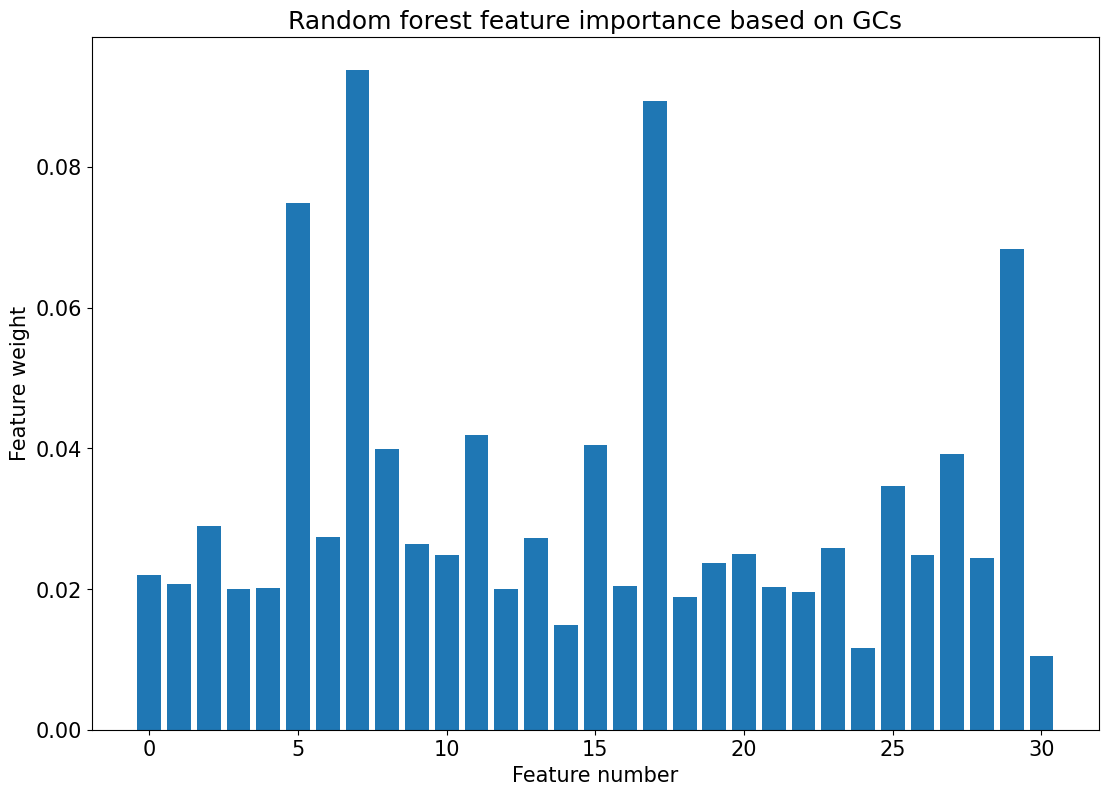

In [83]:
case_name='H17.06.014'
case_number=4

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H17.06.015 (WG1)

Number of cells in H17.06.015
17
Random forest classification score: 1.0


Random forest oob classification performance: 0.7894736842105263
2 classes
Probaility that H17.06.015 cells is WG1
0.5882352941176471


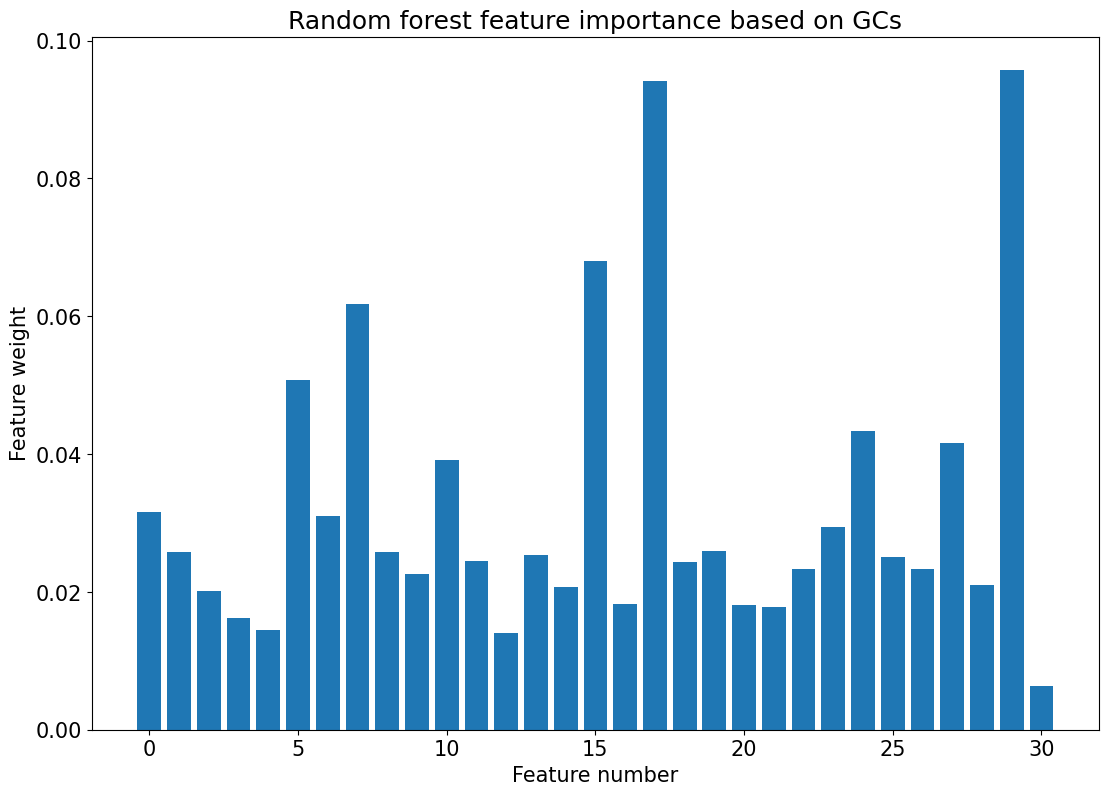

In [84]:
case_name='H17.06.015'
case_number=5

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H18.06.366 (WG4)

Number of cells in H18.06.366
27
Random forest classification score: 1.0


Random forest oob classification performance: 0.8470588235294118
2 classes
Probaility that H18.06.366 cells is WG1
0.7777777777777778


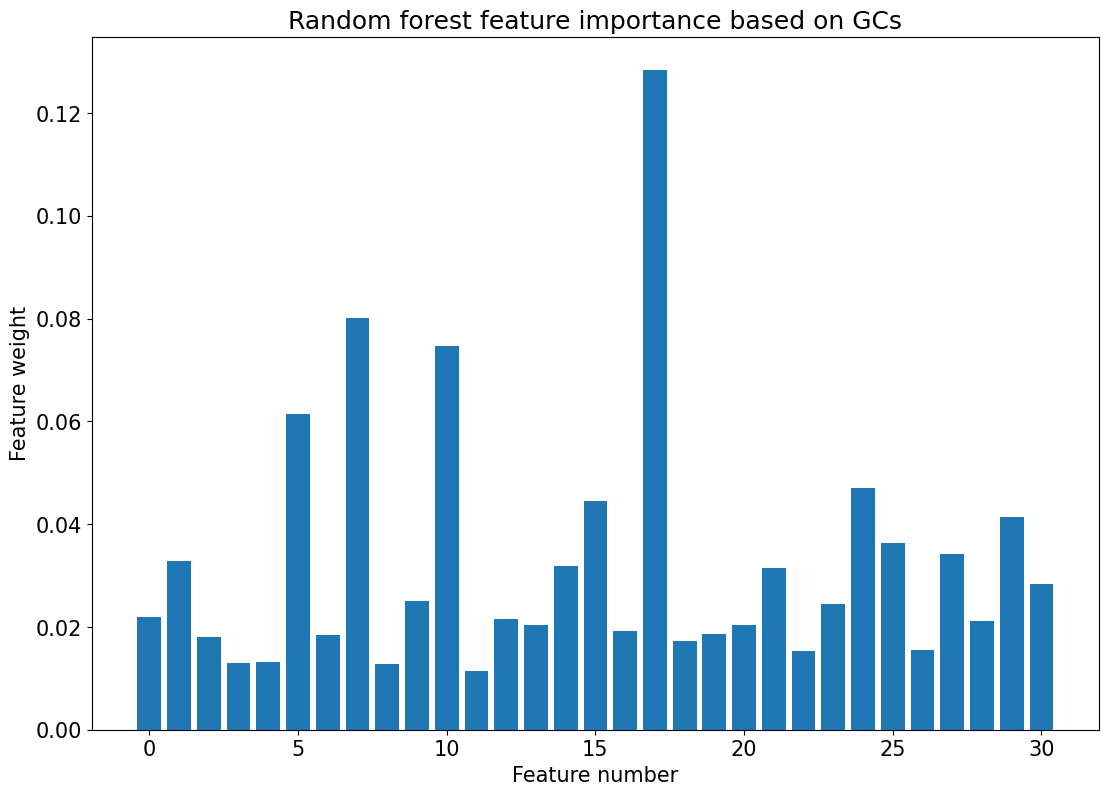

In [85]:
case_name='H18.06.366'
case_number=6

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# H18.06.368 (WG1)

Number of cells in H18.06.368
26
Random forest classification score: 1.0


Random forest oob classification performance: 0.8604651162790697
2 classes
Probaility that H18.06.368 cells is WG1
0.7692307692307693


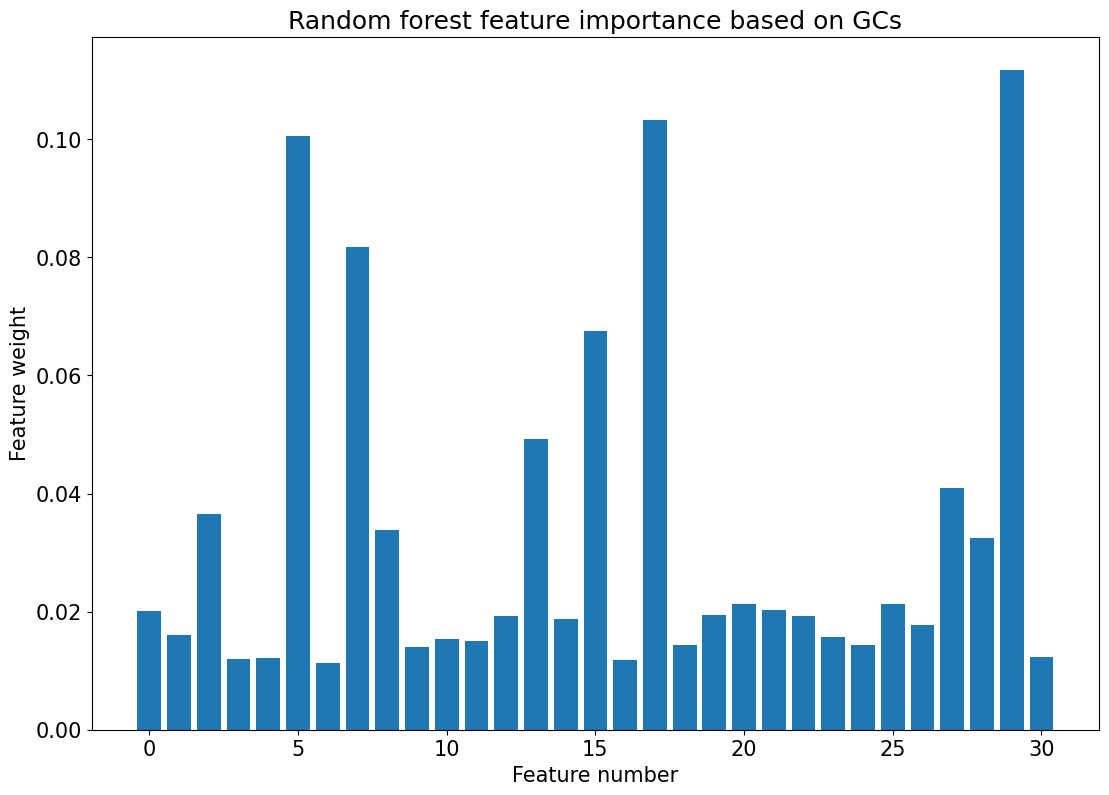

In [86]:
case_name='H18.06.368'
case_number=7

wg1_prob=check_the_case(case_name,case_number,patient_label,all_features_new_scaled)

# Doing PCA on data: split based on patients

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


explained variance ratio (first two components): [0.15221666 0.13726672]


Text(0, 0.5, 'Principal component 2')

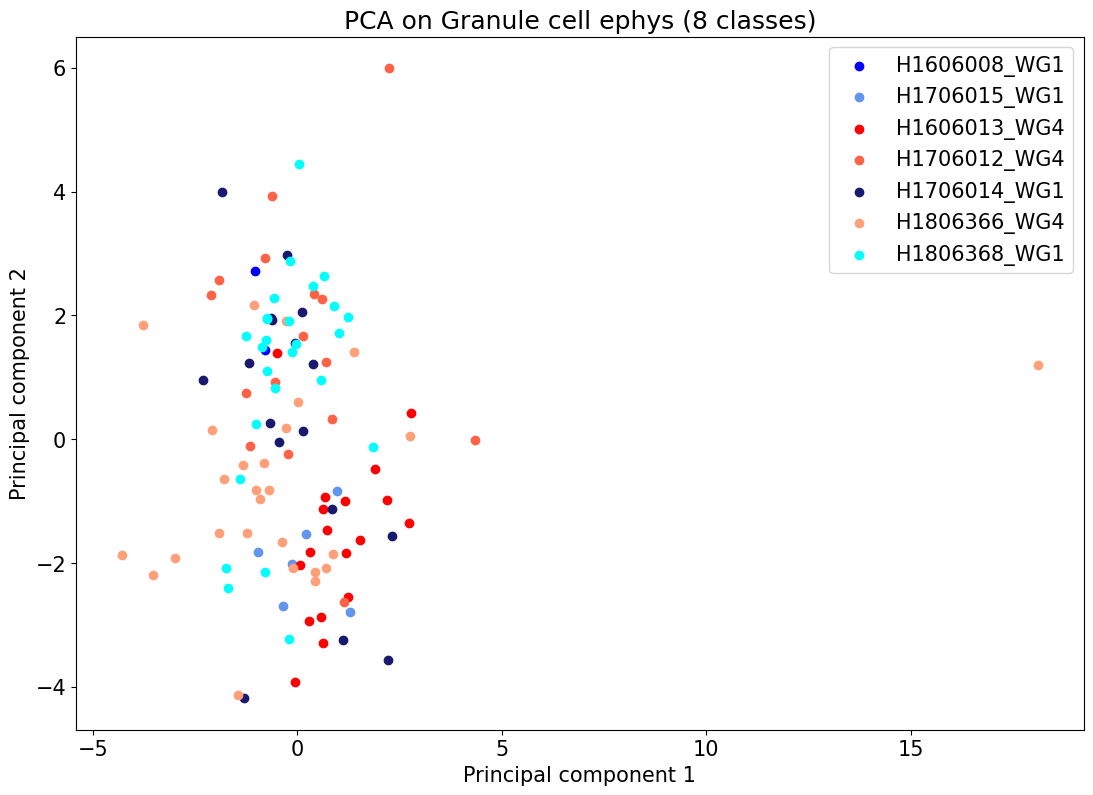

In [87]:

pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
idx_1=np.zeros(1)
idx_2=np.zeros(1)
idx_3=np.zeros(1)
idx_4=np.zeros(1)
idx_5=np.zeros(1)
idx_6=np.zeros(1)
idx_7=np.zeros(1)
idx_8=np.zeros(1)


idx_1=np.where(patient_label==1)
idx_2=np.where(patient_label==2)
idx_3=np.where(patient_label==3)
idx_4=np.where(patient_label==4)
idx_5=np.where(patient_label==5)
idx_6=np.where(patient_label==6)
idx_7=np.where(patient_label==7)


fig, ax = plt.subplots()

plt.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
plt.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='cornflowerblue')
plt.scatter(X_r[idx_3, 0],X_r[idx_3, 1],c='red')
plt.scatter(X_r[idx_4, 0],X_r[idx_4, 1],c='tomato')
plt.scatter(X_r[idx_5, 0],X_r[idx_5, 1],c='midnightblue')
plt.scatter(X_r[idx_6, 0],X_r[idx_6, 1],c='lightsalmon')
plt.scatter(X_r[idx_7, 0],X_r[idx_7, 1],c='cyan')


plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (8 classes)')

plt.legend(['H1606008_WG1','H1706015_WG1','H1606013_WG4','H1706012_WG4','H1706014_WG1','H1806366_WG4','H1806368_WG1'])

plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
#plt.savefig('PCA_by_case.eps', format='eps', dpi=300)



# Doing PCA on data: split based on WG (2 classes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


explained variance ratio (first two components): [0.15221666 0.13726672]


Text(0, 0.5, 'Principal component 2')

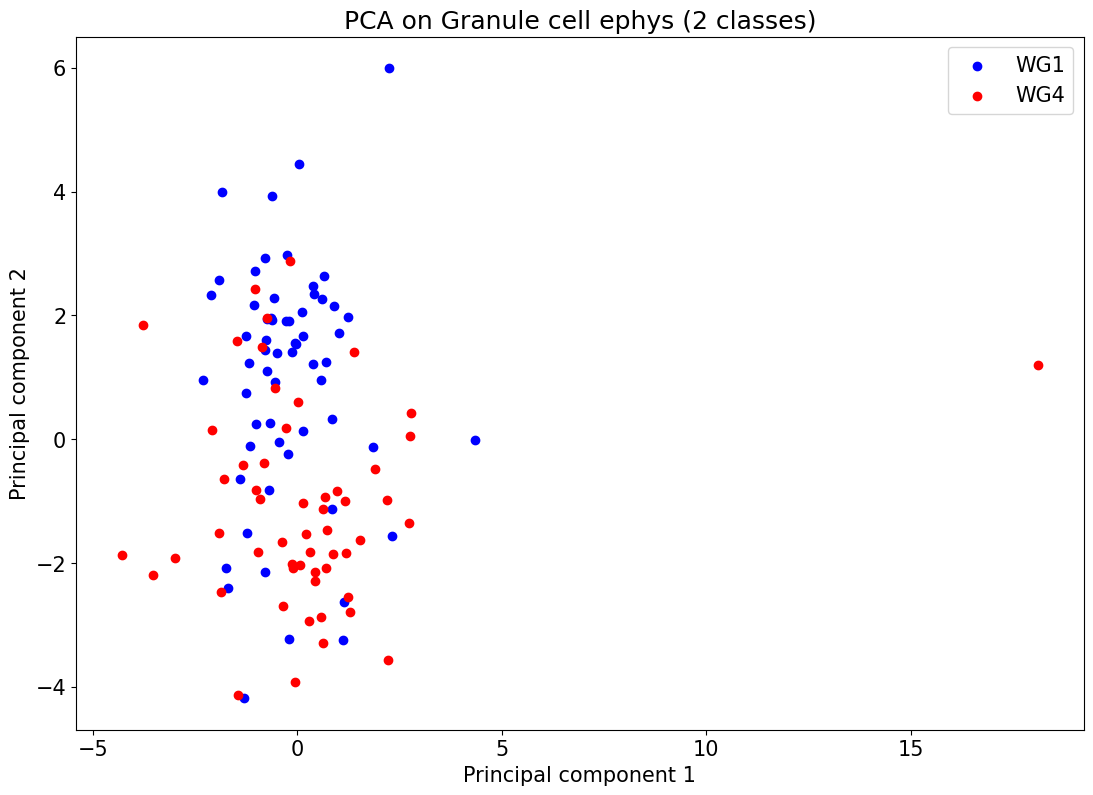

In [88]:

pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
wg1_idx=np.zeros(1)
wg4_idx=np.zeros(1)

wg1_idx=np.where((cell_type==1))[0]
wg4_idx=np.where((cell_type==4))[0]


fig, ax = plt.subplots()

plt.scatter(X_r[wg1_idx, 0],X_r[wg1_idx, 1],c='blue')
plt.scatter(X_r[wg4_idx, 0],X_r[wg4_idx, 1],c='red')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (2 classes)')
plt.legend(['WG1','WG4'])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
#plt.savefig('PCA_2_classes.eps', format='eps', dpi=300)


# PCA on data: split based on WG + show the model cells

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


explained variance ratio (first two components): [0.15221666 0.13726672]


Text(0, 0.5, 'Principal component 2')

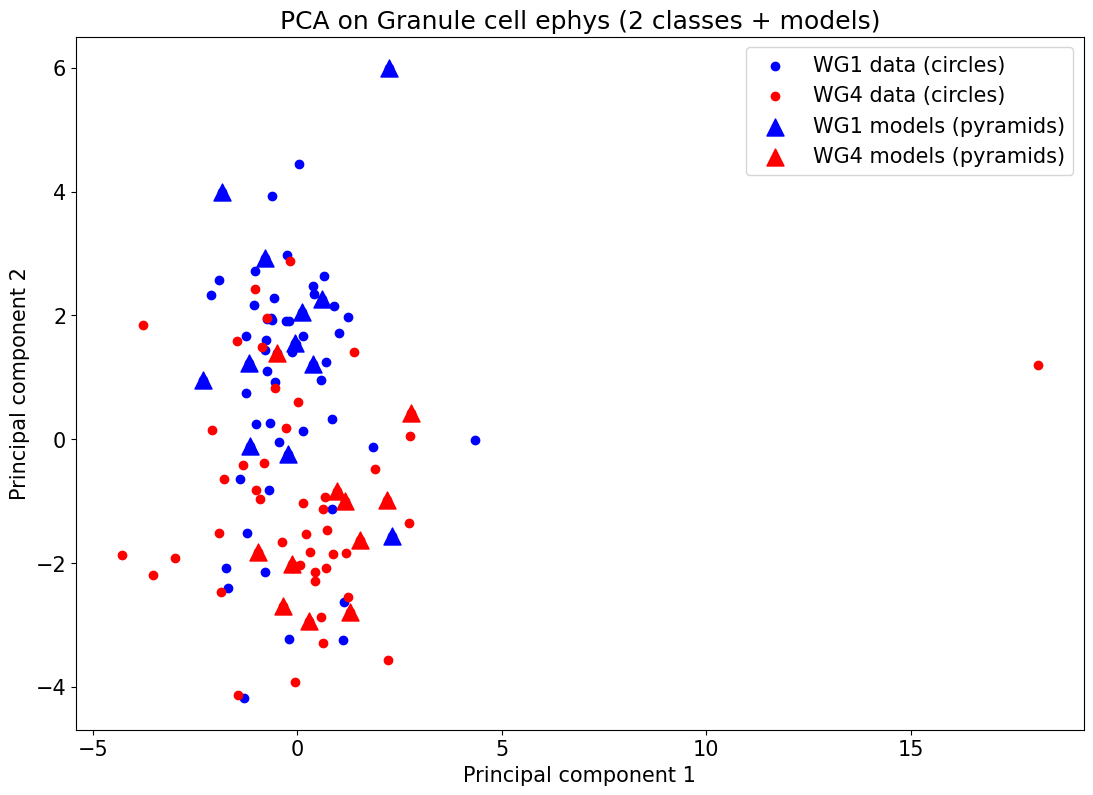

In [93]:

pca = PCA(n_components=2)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# print the variance explained
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

# create the colors vectors
#colors = np.heaviside(cell_type-2,1)

# all indexes of WG
wg1_idx=np.zeros(1)
wg4_idx=np.zeros(1)
wg1_model_idx=np.zeros(1)
wg4_model_idx=np.zeros(1)

wg1_idx=np.where((cell_type==1))[0]
wg4_idx=np.where((cell_type==4))[0]
wg1_model_idx=wg1_best_idx
wg4_model_idx=wg4_best_idx


fig, ax = plt.subplots()

# plot the main data
plt.scatter(X_r[wg1_idx, 0],X_r[wg1_idx, 1],c='blue')
plt.scatter(X_r[wg4_idx, 0],X_r[wg4_idx, 1],c='red')
# plot the model cells
plt.scatter(X_r[wg1_model_idx, 0],X_r[wg1_model_idx, 1],c='blue',marker='^',s=150)
plt.scatter(X_r[wg4_model_idx, 0],X_r[wg4_model_idx, 1],c='red',marker='^',s=150)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on Granule cell ephys (2 classes + models)')
plt.legend(['WG1 data (circles)','WG4 data (circles)','WG1 models (pyramids)','WG4 models (pyramids)'])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
#plt.savefig('PCA_3_classes.eps', format='eps', dpi=300)



# Doing tSNE on data: split based on WG (2 classes) + model cells

Ephys dataset, perplexity=30 in 0.38 sec


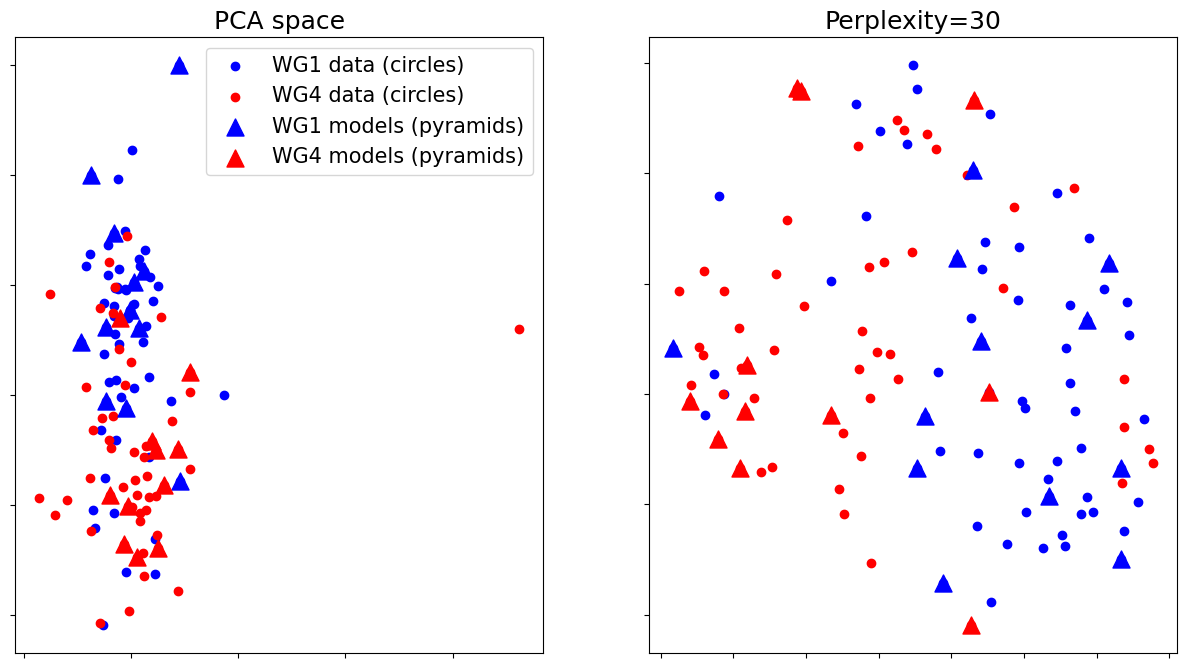

In [100]:
# Aiming to project to 2 componenets
n_components = 2

(fig, subplots) = plt.subplots(1, 2, figsize=(15, 8))
perplexities = [30]

pca = PCA(n_components=30)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)


X = X_r[:,:]
y = cell_type_14

idx_1=np.where(cell_type==1)
idx_2=np.where(cell_type==4)
wg1_model_idx=wg1_best_idx
wg4_model_idx=wg4_best_idx


ax = subplots[0]

ax.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
ax.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='red')

# models
ax.scatter(X_r[wg1_model_idx, 0],X_r[wg1_model_idx, 1],c='blue',marker='^',s=150)
ax.scatter(X_r[wg4_model_idx, 0],X_r[wg4_model_idx, 1],c='red',marker='^',s=150)


ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
ax.set_title('PCA space')

# split by case type
ax.legend(['WG1 data (circles)','WG4 data (circles)','WG1 models (pyramids)','WG4 models (pyramids)'])


for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, metric='cosine',n_iter=20000)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Ephys dataset, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)

    # plot different cells with different labels
    
    ax.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
    ax.scatter(Y[idx_2, 0],Y[idx_2, 1],c='red')
    ax.scatter(Y[wg1_model_idx, 0],Y[wg1_model_idx, 1],c='blue',marker='^',s=150)
    ax.scatter(Y[wg4_model_idx, 0],Y[wg4_model_idx, 1],c='red',marker='^',s=150)

    
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

#plt.savefig('tSNE_perplexity_20_CASE.eps', format='eps', dpi=300)

# Pairwise features comparison

Indexes of wg1 and wg4 cells
[  0   1  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107]
[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81 108 109 110 111 112 113 114
 115]
adaptation_slope
0.39758263082488465
adaptation_slope_rheobase
0.03515465461497806
AP_through_rheobase
0.2094435540266577
AP_downstroke_slope
0.17553862730085024
voltage_base_mean
0.2501254130605257
Time_to_spike_slope
3.2125074915342906e-05
R_in
0.2094435540266577
First_ISI_slope
3.2911401640911065e-05
AP_thr_rheobase
0.0040388415036870145
AP_upstroke_slope
0.1459066071487345
voltage_base_sigma
0.008492551350257138
AP_through_slope
0.012256745155245177
Time_to_spike_slope_rheobase
0.19958151

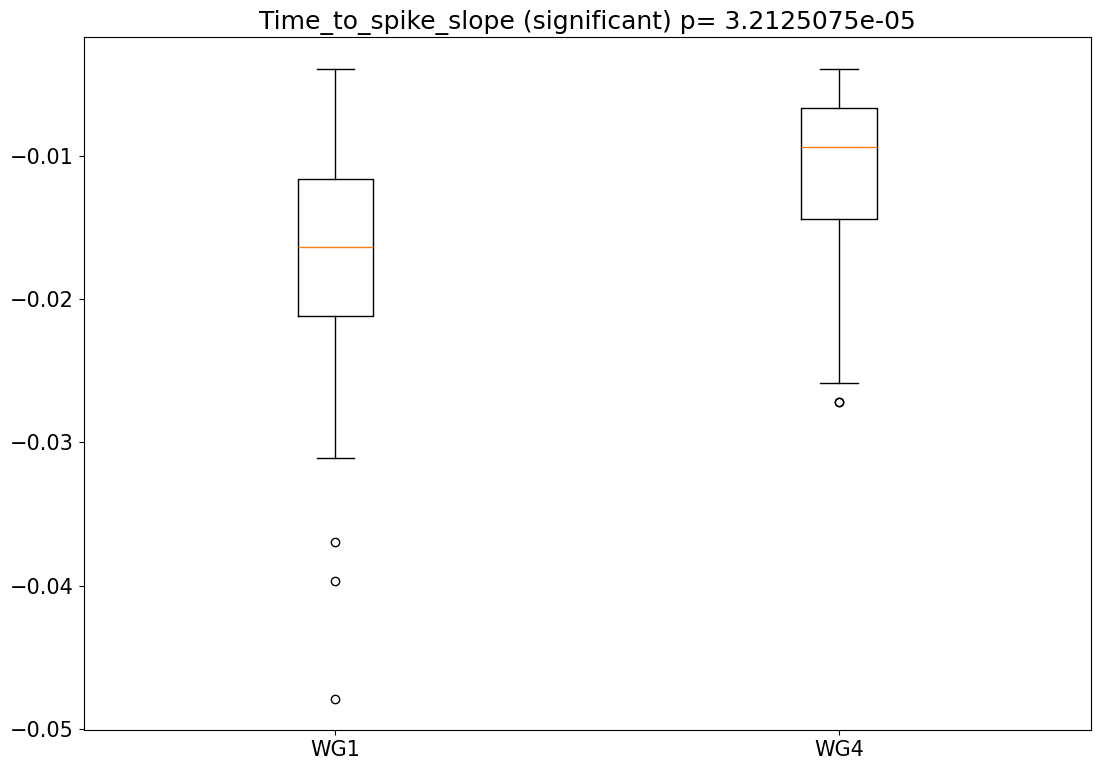

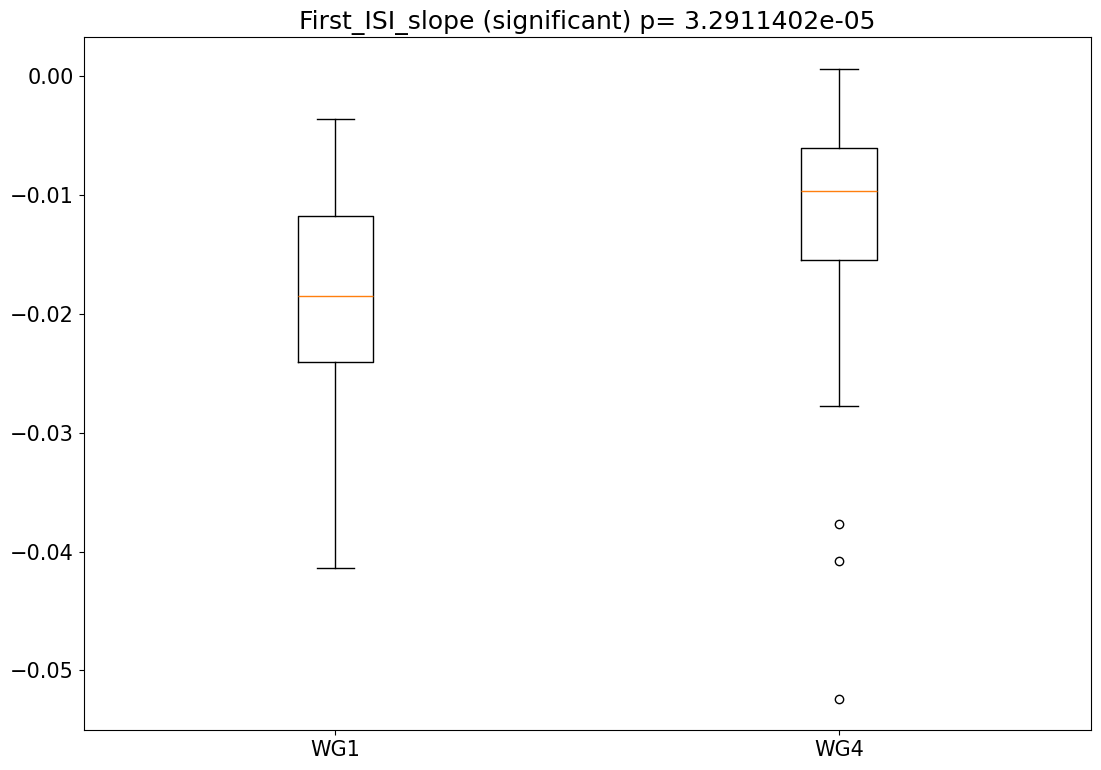

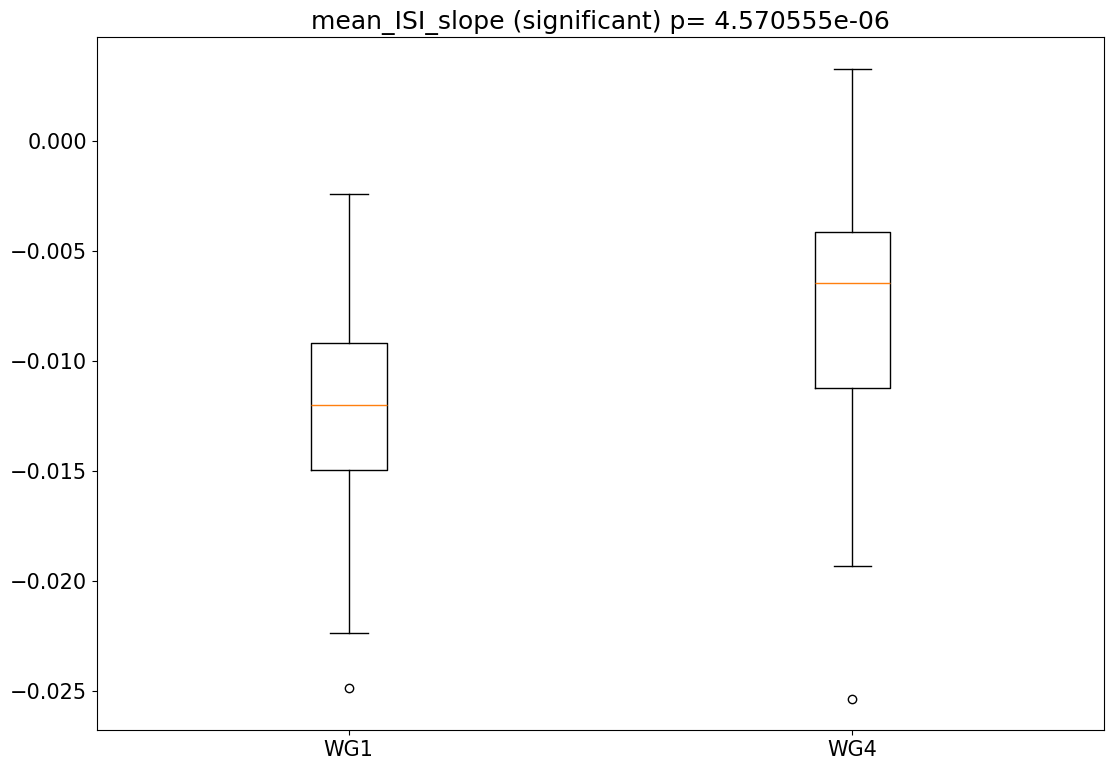

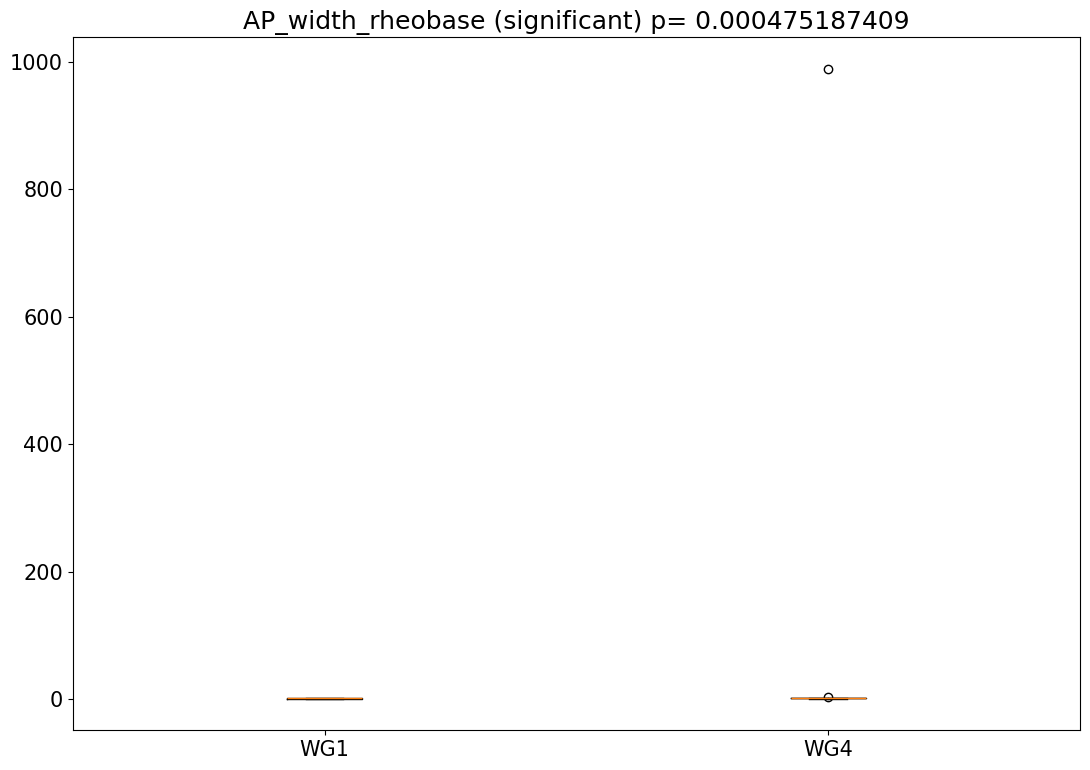

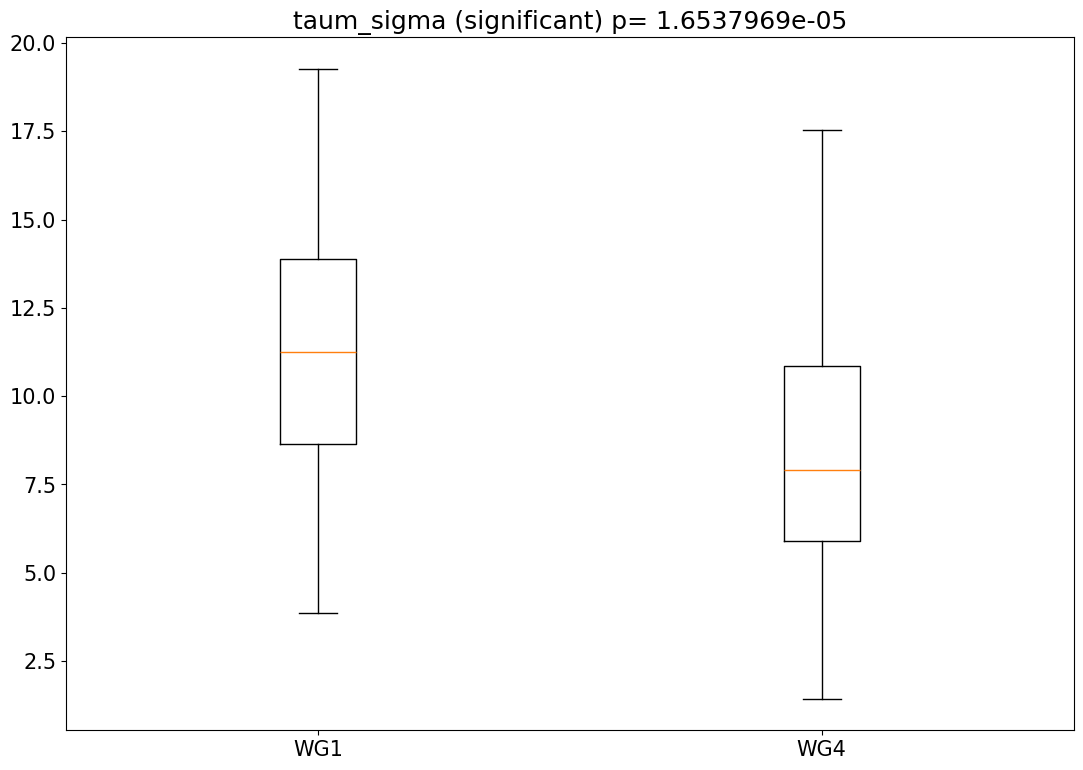

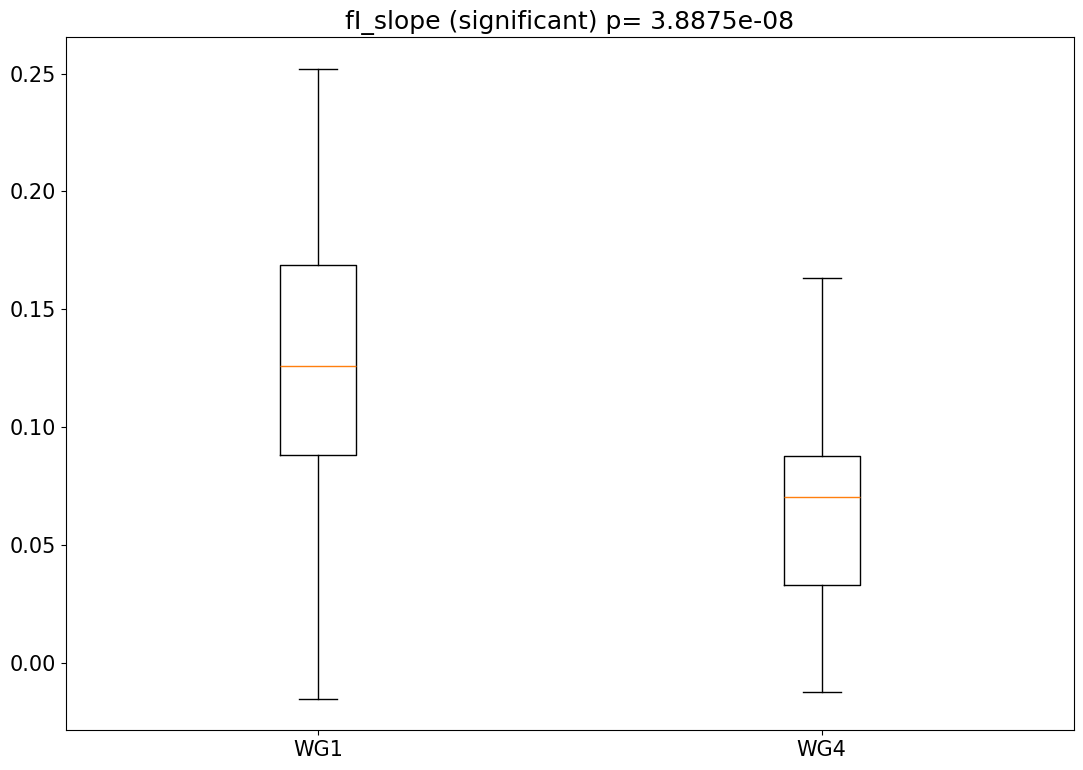

In [102]:
# find indexes of wg1 and wg4 neurons

wg1_idx=np.where(all_features_matrix_no_nan[:,0] == 1)[0]
wg4_idx=np.where(all_features_matrix_no_nan[:,0] == 4)[0]

# sign level
alpha_level=0.05

print('Indexes of wg1 and wg4 cells')
print(wg1_idx)
print(wg4_idx)

# compare all features and compute p_values

p_values=np.zeros(n_features)

# plot the box plots for all cells

for i in np.arange(n_features):

    feature_1=all_features_matrix_no_nan[wg1_idx,i+1]
    feature_2=all_features_matrix_no_nan[wg4_idx,i+1]
    
    # remove nans
    feature_1 = feature_1[~np.isnan(feature_1)]
    feature_2 = feature_2[~np.isnan(feature_2)]

    d,p=stats.mannwhitneyu(feature_1,feature_2)
    print(feature_names[i])
    print(p)
    # record the p_values
    p_values[i]=p

    # plot the results        
    if p<alpha_level/n_features:
        fig, ax = plt.subplots()
        labels=['WG1','WG4']
    #    plt.violinplot([feature_1,feature_2])
        plt.boxplot([feature_1,feature_2])

        plt.title(feature_names[i]+str(' (significant)') +str(' p= ') +str(np.round(p,12)))
#    else:
#        plt.title(feature_names[i]+str(' (non-significant)') +str(' p= ') +str(np.round(p,12)))
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(labels) + 1))
        ax.set_xticklabels(labels)
    # save figure part
#   plt.savefig(str(str(feature_names[i])+'.eps'), format='eps', dpi=300)

# p-values order is the same for all features and further analysis

p_values of 31 feature:31 features
[3.97582631e-01 3.51546546e-02 2.09443554e-01 1.75538627e-01
 2.50125413e-01 3.21250749e-05 2.09443554e-01 3.29114016e-05
 4.03884150e-03 1.45906607e-01 8.49255135e-03 1.22567452e-02
 1.99581513e-01 6.66274383e-01 4.96674564e-02 2.44613854e-03
 8.90061380e-01 4.57055471e-06 9.51502819e-01 1.63521979e-01
 7.77705998e-02 2.19652873e-01 8.33586237e-01 2.93478316e-01
 4.75187409e-04 9.94223863e-02 8.03509478e-01 1.65379692e-05
 2.86980054e-02 3.88750846e-08 3.86797555e-03]




([<matplotlib.axis.XTick at 0x184c7cda0>,
 [Text(0, 0, '29'),
  Text(1, 0, '17'),
  Text(2, 0, '27'),
  Text(3, 0, '5'),
  Text(4, 0, '7'),
  Text(5, 0, '24'),
  Text(6, 0, '15'),
  Text(7, 0, '30'),
  Text(8, 0, '8'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '28'),
  Text(12, 0, '1'),
  Text(13, 0, '14'),
  Text(14, 0, '20'),
  Text(15, 0, '25'),
  Text(16, 0, '9'),
  Text(17, 0, '19'),
  Text(18, 0, '3'),
  Text(19, 0, '12'),
  Text(20, 0, '2'),
  Text(21, 0, '6'),
  Text(22, 0, '21'),
  Text(23, 0, '4'),
  Text(24, 0, '23'),
  Text(25, 0, '0'),
  Text(26, 0, '13'),
  Text(27, 0, '26'),
  Text(28, 0, '22'),
  Text(29, 0, '16'),
  Text(30, 0, '18')])

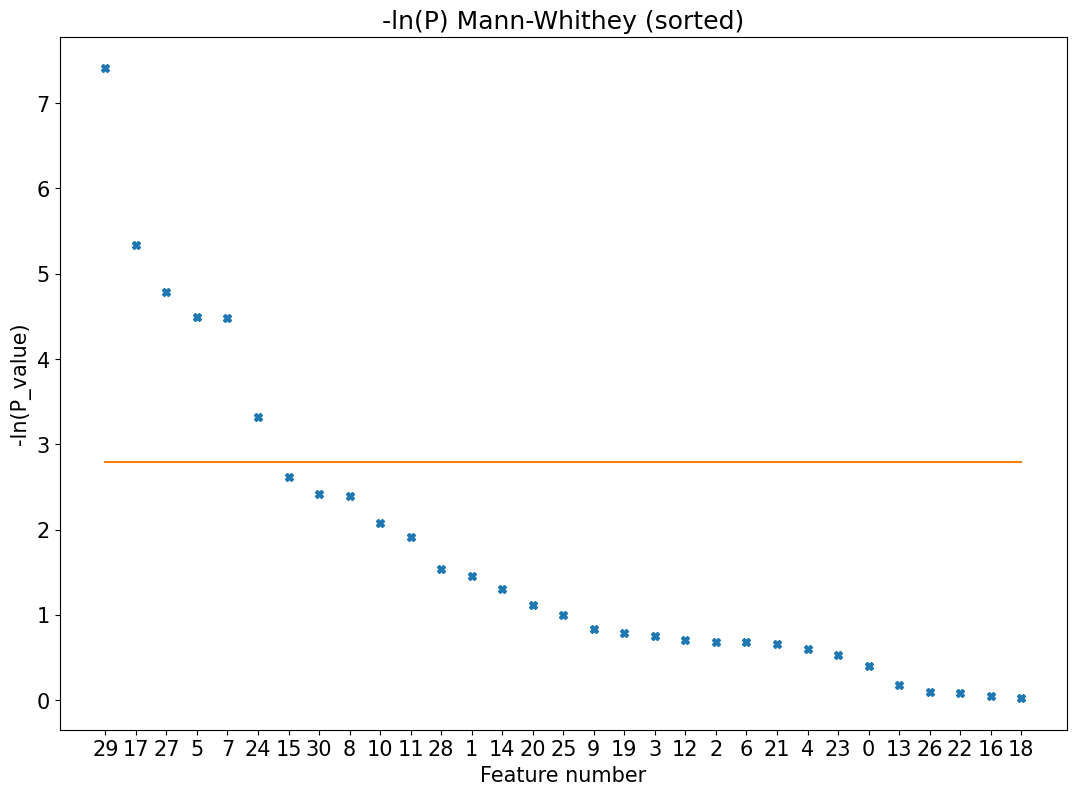

In [103]:
print('p_values of 31 feature:' +str(len(p_values)) +str(' features'))
print(p_values)
print('\n')

# significance level
alpha_level=0.05
p_level=alpha_level/n_features
sign_level=np.zeros(n_features)
sign_level[:]=-np.log10(p_level)
log_p=-np.log10(p_values) # initial log_p


plt.plot(np.arange(0,n_features,1),log_p[np.flip(np.argsort(-np.log10(p_values)),0)],'X',np.arange(0,n_features,1),sign_level)
plt.title('-ln(P) Mann-Whithey (sorted)')
plt.ylabel('-ln(P_value)')
plt.xlabel('Feature number')

# xticks
plt.xticks(np.arange(0,n_features,1),np.flip(np.argsort(-np.log(p_values)),0))

#print np.flip(np.argsort(-np.log(p_values)),0)

# Show two features leading separation

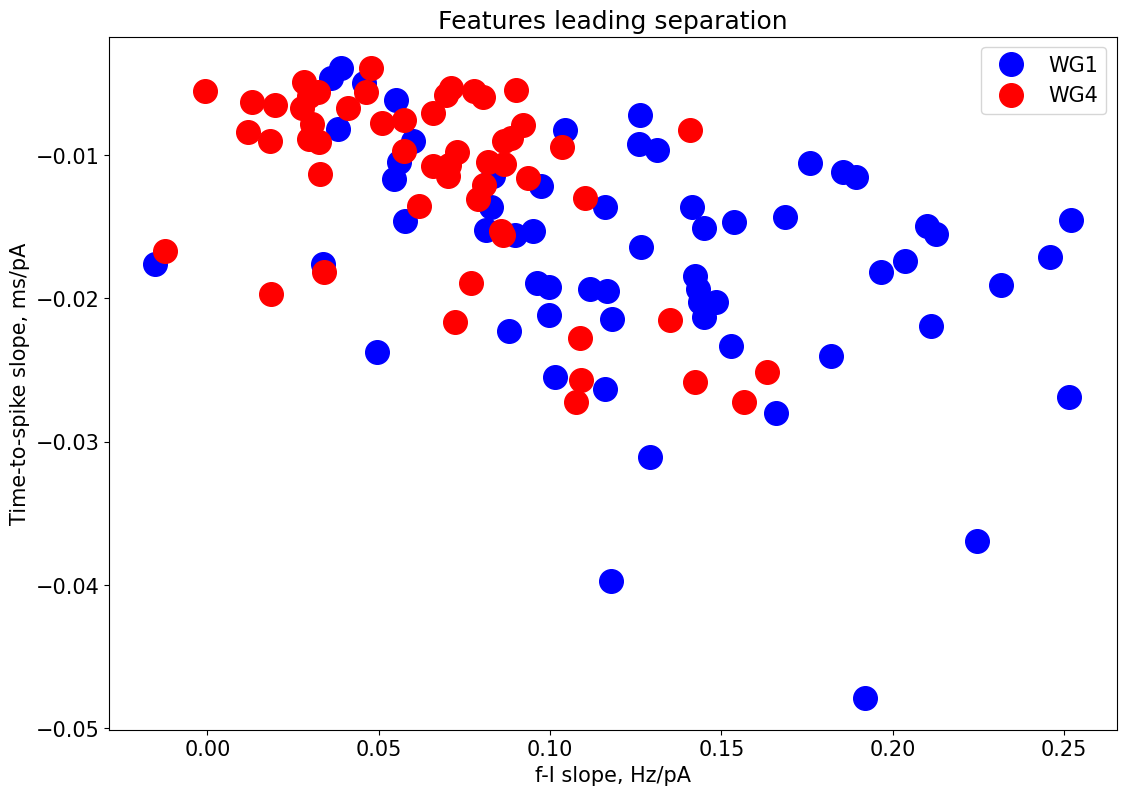

In [104]:

# find indexes of WG1 and WG4 cells
wg1_idx=np.where(all_features_matrix_no_nan[:,0] == 1)[0]
wg4_idx=np.where(all_features_matrix_no_nan[:,0] == 4)[0]

# f-I slope
x_f_wg1 = all_features_matrix_no_nan[wg1_idx,-2]
y_f_wg1 = all_features_matrix_no_nan[wg1_idx,6]
z_f_wg1 = all_features_matrix_no_nan[wg1_idx,18]

# time-to-spike slope
x_f_wg4 = all_features_matrix_no_nan[wg4_idx,-2]
y_f_wg4 = all_features_matrix_no_nan[wg4_idx,6]
z_f_wg4 = all_features_matrix_no_nan[wg4_idx,18]

# plot the results
plt.plot(x_f_wg1,y_f_wg1,'.',c='blue', markersize=34)
plt.plot(x_f_wg4,y_f_wg4,'.',c='red', markersize=34)
plt.xlabel('f-I slope, Hz/pA')
plt.ylabel('Time-to-spike slope, ms/pA')
plt.title('Features leading separation')
plt.legend(('WG1','WG4'))

# plt.savefig('ephys_features_2D.pdf',format = 'pdf')


## Show separating features in 3D

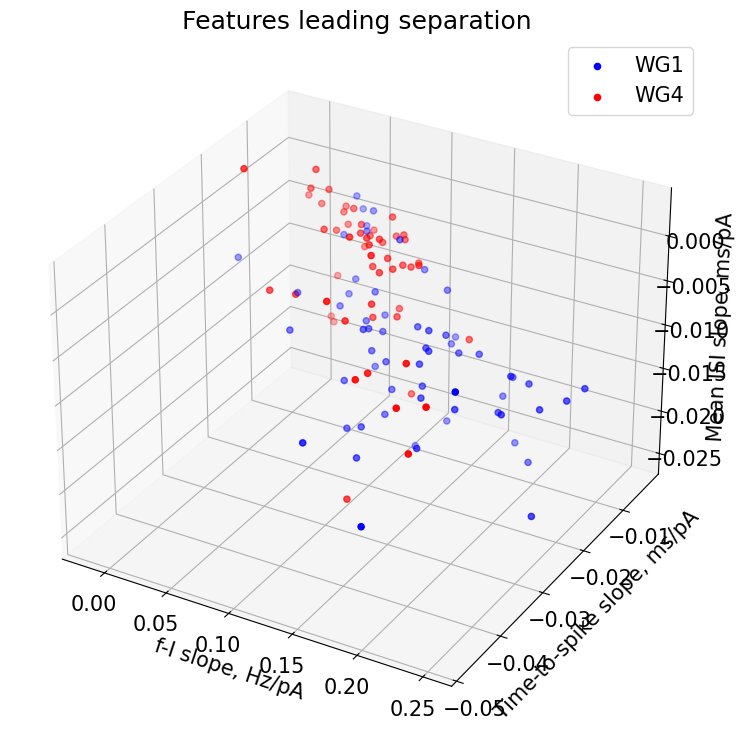

In [105]:

#%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the results
ax.scatter(x_f_wg1,y_f_wg1,z_f_wg1,c='blue', marker='o')
ax.scatter(x_f_wg4,y_f_wg4,z_f_wg4,c='red',marker='o')
plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.autoscale(enable=True, axis='z', tight=True)
ax.set_xlabel('f-I slope, Hz/pA')
ax.set_ylabel('Time-to-spike slope, ms/pA')
ax.set_zlabel('Mean ISI slope, ms/pA')
ax.set_title('Features leading separation')
plt.legend(('WG1','WG4'))


# Plot p-values as a bar plot

Text(0.5, 1.0, '-ln(P) Mann-Whithney (unsorted)')

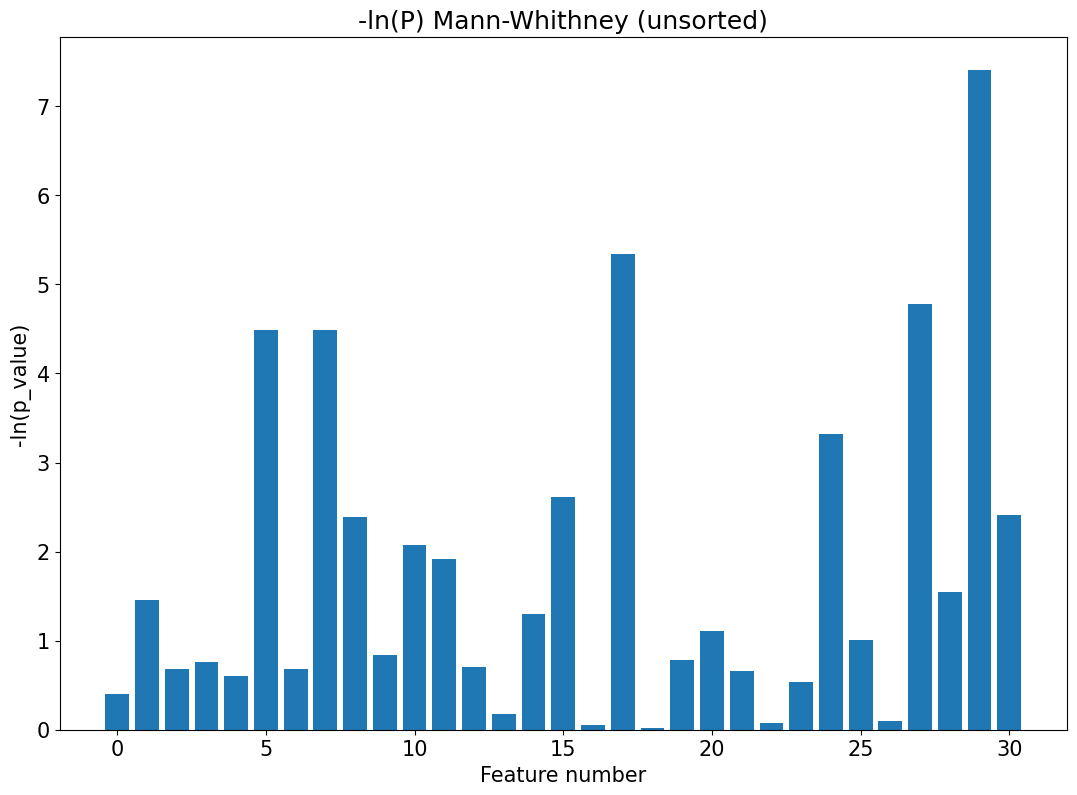

In [106]:
# PLOT p-values as a bar plot

# p-values order is different from all other features

# significance level
p_level=alpha_level/n_features
sign_level=np.zeros(n_features)
sign_level[:]=-np.log10(p_level)
log_p=-np.log10(p_values) # initial log_p


plt.bar(np.arange(0,n_features,1),log_p)
plt.ylabel('-ln(p_value)')
plt.xlabel('Feature number')
plt.title('-ln(P) Mann-Whithney (unsorted)')

# save figure to eps
#plt.savefig('all_features_MannWhithney_bonferoni.eps',format='eps',dpi=300)

# Plot 10 most distinct features (p-values)

Names of the important features:


fI_slope
mean_ISI_slope
taum_sigma
Time_to_spike_slope
First_ISI_slope
AP_width_rheobase
AP_up/downstroke_rheobase
Rheobase_freq
AP_thr_rheobase
voltage_base_sigma


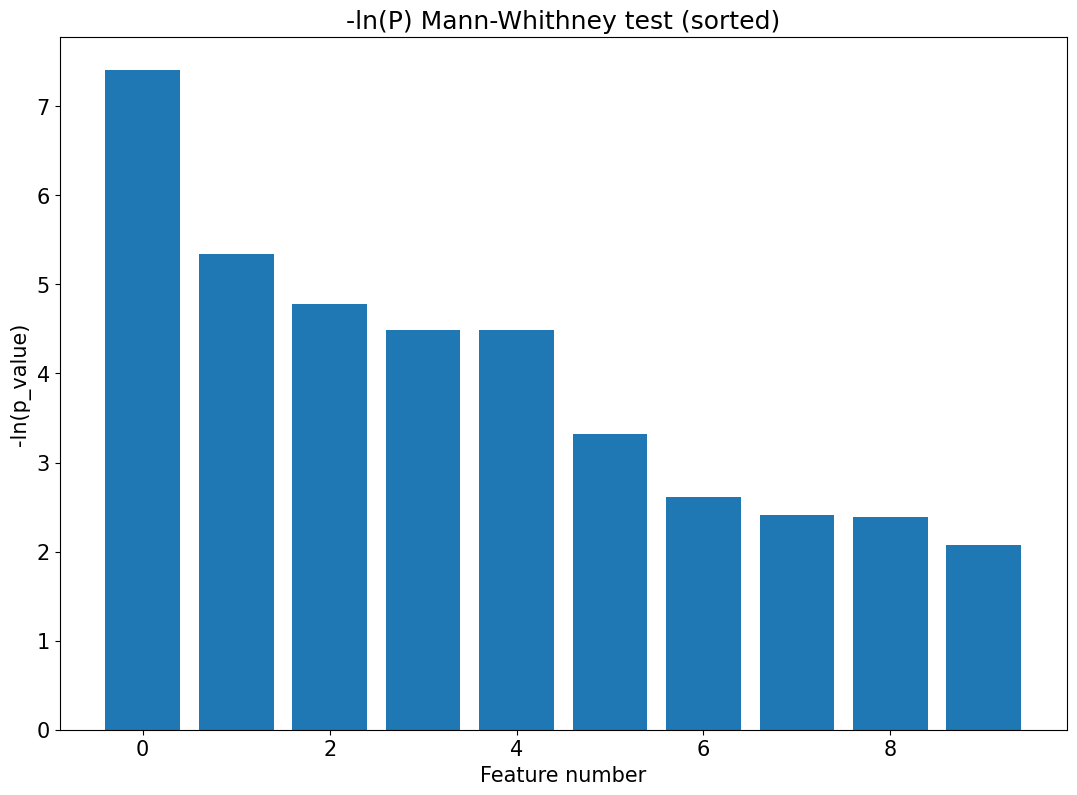

In [107]:
feature_order_idx=np.flip(np.argsort(-np.log10(p_values)),0)
feature_to_show=10

plt.bar(np.arange(0,feature_to_show,1),log_p[feature_order_idx[0:feature_to_show]])
plt.ylabel('-ln(p_value)')
plt.xlabel('Feature number')
plt.title('-ln(P) Mann-Whithney test (sorted)')

# show the feature order idx
print('Names of the important features:')
print('\n')
for i in range(feature_to_show):
    print(feature_names[feature_order_idx[i]])

# save figure to eps
#plt.savefig('all_features_Mann_Whithney_bonferoni_10most_significant.eps',format='eps',dpi=300)

# Show features in the PCA space

Text(0.5, 1.0, 'All features in PCA-space')

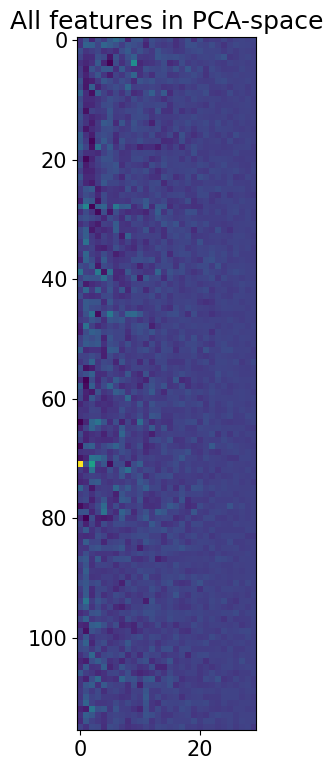

In [108]:

pca = PCA(n_components=30)
# get the cell positions in the new coordinates, X_r - the dataset in the PCA space
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)

# show all features projected in the PCA space

plt.imshow(X_r)
plt.title('All features in PCA-space')


# Random forest classification for 2 classes

Random forest classification score: 1.0


Random forest classification performance: 0.7758620689655172
2 classes
Sum of feature importances: 1.0000000000000002
Order of features
[17 29 15 27  7  5 11 13 28 23  2 10  6 25  8 24  9  1 21  0 22 20 26 12
 19  4 16  3 14 18 30]


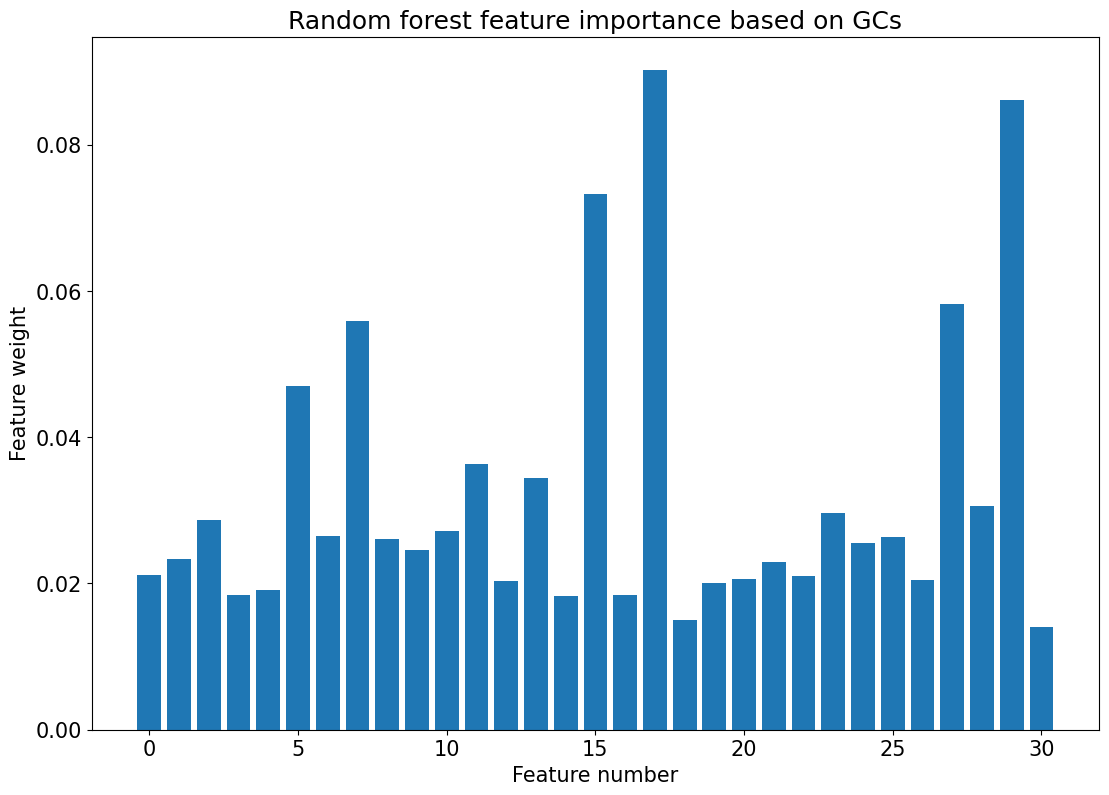

In [109]:
# do random forest classifier on original data

# CELL_TYPES FOR WG1+WG1TS, WG4

# process the cell type: WG1TS -> WG1 conversion
cell_type_14=np.array(cell_type)
#cell_type_14[np.where(cell_type_14 == 11)]=1

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

#RandomForestClassifier(max_depth=None, random_state=0)
clf.fit(all_features_new_scaled, cell_type_14)

# get the scores of the trees and pring them
scores = clf.score(all_features_new_scaled, cell_type_14)
print('Random forest classification score: ' + str(scores))


oob_error = clf.oob_score_
print('\n')
print('Random forest classification performance: ' + str(oob_error))
print('2 classes')
feature_importance=clf.feature_importances_

# [np.flip(np.argsort(feature_importance),0)]
plt.bar(np.arange(0,n_features,1), feature_importance)


plt.title('Random forest feature importance based on GCs')
plt.xlabel('Feature number')
plt.ylabel('Feature weight')

#plt.xticks(np.arange(0,n_features,1),np.flip(np.argsort(feature_importance),0))
print('Sum of feature importances: ' + str(np.sum(clf.feature_importances_)))
print('Order of features')
print(np.flip(np.argsort(feature_importance),0))


# save the results in figures
#plt.bar(np.arange(0,n_features,1),log_p)
#plt.savefig('Random_forest_WG1WG1TS_WG4_weights.eps', format='eps', dpi=300)

# Show the feature importance of 10 most important features

Names of the important features:


mean_ISI_slope
fI_slope
AP_up/downstroke_rheobase
taum_sigma
First_ISI_slope
Time_to_spike_slope
AP_through_slope
AP_height_slope
Rheobase_current


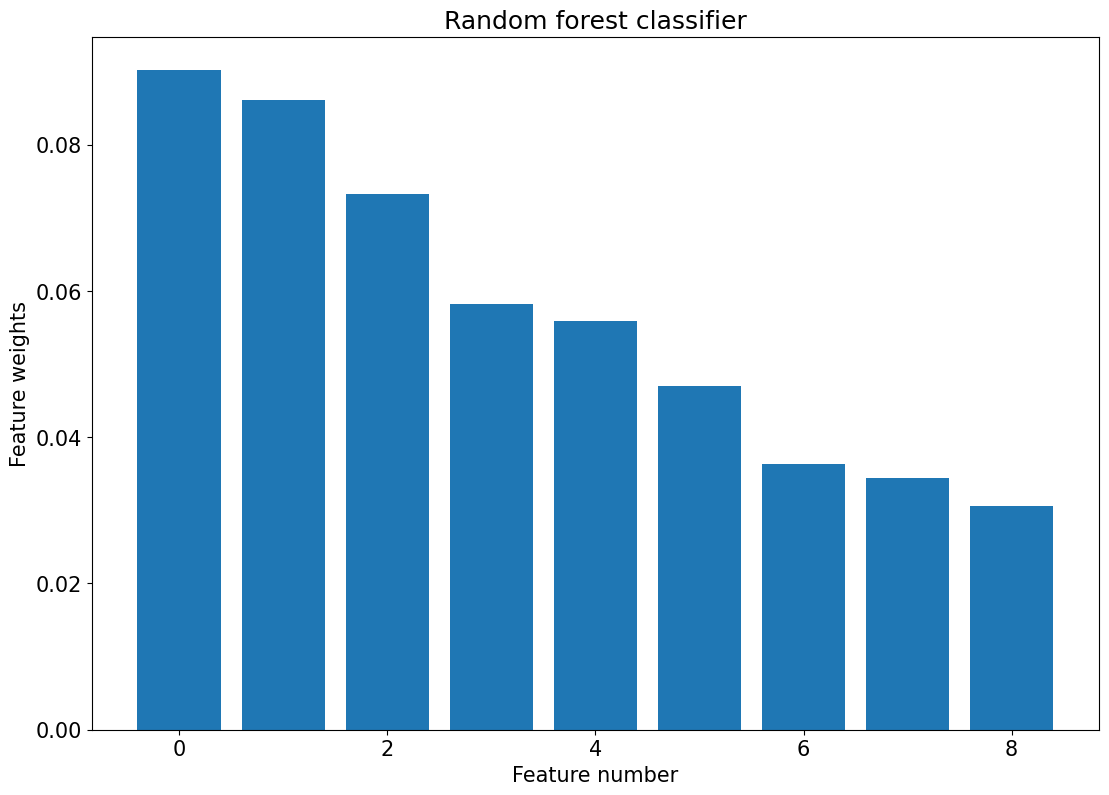

In [111]:

# feature order
feature_order_idx=np.flip(np.argsort(feature_importance),0)
feature_to_show=9


plt.bar(np.arange(0,feature_to_show,1),feature_importance[feature_order_idx[0:feature_to_show]])
plt.ylabel('Feature weights')
plt.xlabel('Feature number')
plt.title('Random forest classifier')

# show the feature order idx
print('Names of the important features:')
print('\n')
for i in range(feature_to_show):
    print(feature_names[feature_order_idx[i]])

# save figure to eps
#plt.savefig('all_features_random_forest_10_largest.eps',format='eps',dpi=300)

# Run tSNE and PCA analysis based on ephys feature set

Ephys dataset, perplexity=30 in 0.32 sec


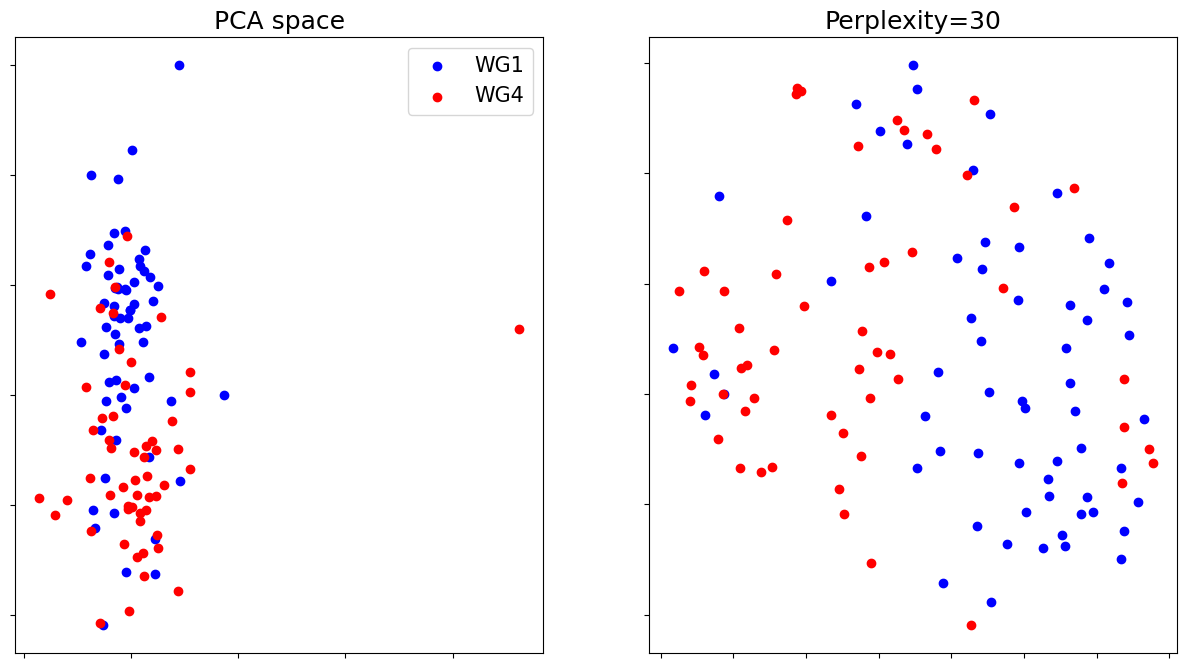

In [112]:

# Dataset description
#n_samples = 119

# Aiming to project to 2 componenets
n_components = 2

(fig, subplots) = plt.subplots(1, 2, figsize=(15, 8))
perplexities = [30]

pca = PCA(n_components=30)
# get the cell positions in the new coordinates
X_r = pca.fit(all_features_new_scaled).transform(all_features_new_scaled)


X = X_r[:,:]
y = cell_type_14

idx_1=np.where(cell_type==1)
idx_2=np.where(cell_type==4)


ax = subplots[0]

ax.scatter(X_r[idx_1, 0],X_r[idx_1, 1],c='blue')
ax.scatter(X_r[idx_2, 0],X_r[idx_2, 1],c='red')

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
ax.set_title('PCA space')

# split by case type
ax.legend(['WG1','WG4'])


for i, perplexity in enumerate(perplexities):
    ax = subplots[i + 1]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, metric='cosine',n_iter=20000)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("Ephys dataset, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)

    # plot different cells with different labels
    
    ax.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
    ax.scatter(Y[idx_2, 0],Y[idx_2, 1],c='red')
    
    
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

    
#plt.savefig('tSNE_perplexity_30_CASE.eps', format='eps', dpi=300)

#plt.show()

# plot the tSNE graph with the split across patients

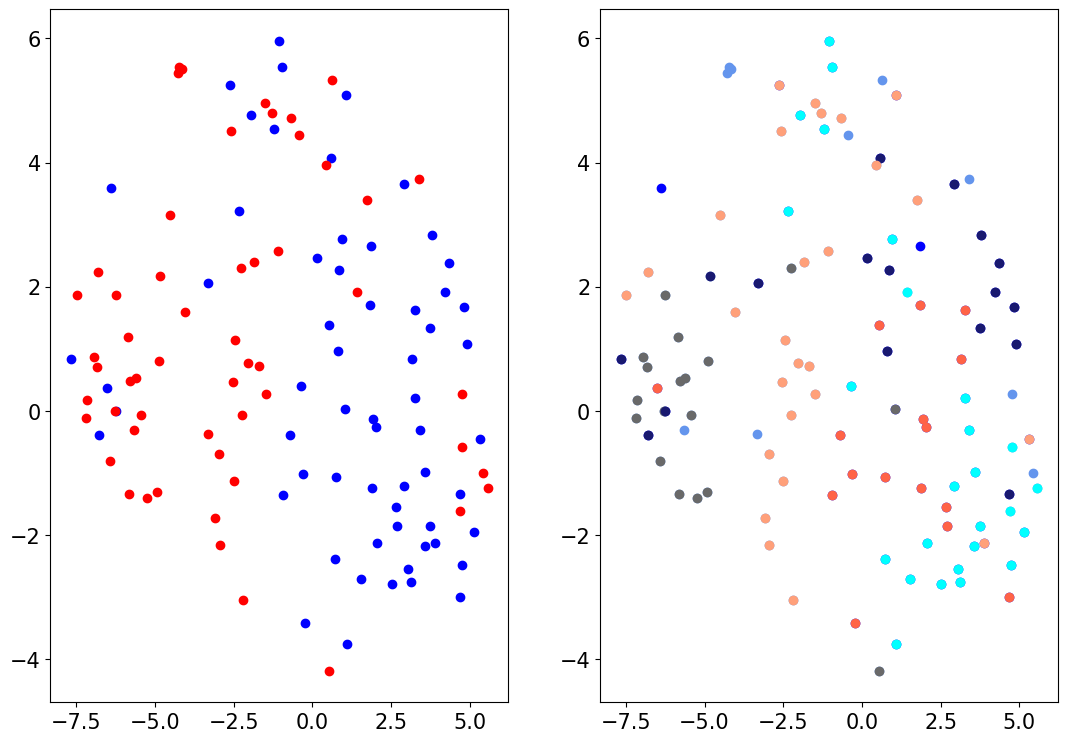

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2)



ax2.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
ax2.scatter(Y[idx_2, 0],Y[idx_2, 1],c='cornflowerblue')
ax2.scatter(Y[idx_3, 0],Y[idx_3, 1],c='dimgrey')
ax2.scatter(Y[idx_4, 0],Y[idx_4, 1],c='tomato')
ax2.scatter(Y[idx_5, 0],Y[idx_5, 1],c='midnightblue')
ax2.scatter(Y[idx_6, 0],Y[idx_6, 1],c='lightsalmon')
ax2.scatter(Y[idx_7, 0],Y[idx_7, 1],c='cyan')
#ax2.title('tSNE')

ax1.scatter(Y[idx_1, 0],Y[idx_1, 1],c='blue')
ax1.scatter(Y[idx_2, 0],Y[idx_2, 1],c='red')

# save the figure
#plt.savefig('tSNE_perplexity_30_patietn_WG.eps', format='eps', dpi=300)


# Running random forest classifier on post tSNE

Classifier performance, tSNE 1 & tSNE 2 projection only: 0.7413793103448276
RandomForest with 200 estimators with features [0, 1] has a score of 1.0


Text(0, 0.5, 'tSNE 2')

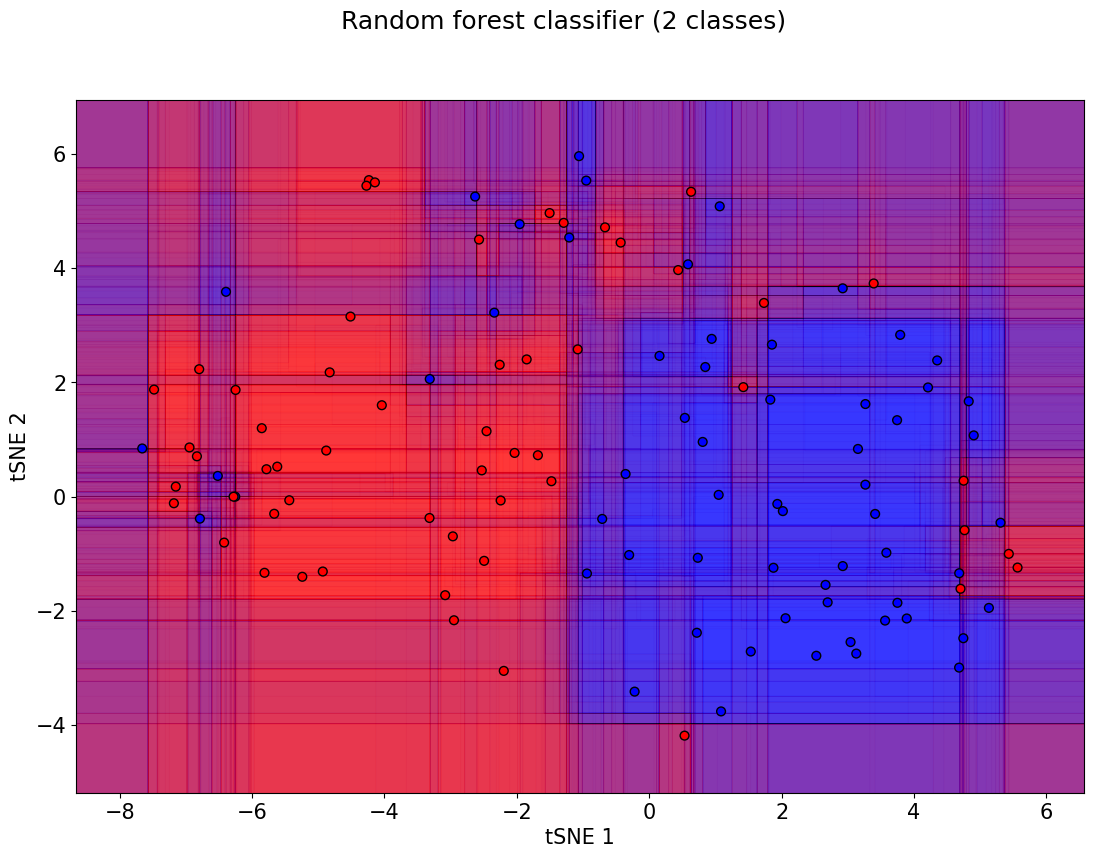

In [114]:
# Plot the decision boundary only for Random forest classifier


# Parameters
n_classes = 2
n_estimators = 200
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration


model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)                    


pair=[0,1]

#X = X_r[:, pair]
X = Y
y = cell_type_14



# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Train
clf = clone(model)
clf = model.fit(X, y)

# get the scores of the trees
scores = clf.score(X, y)

# print the model score
print('Classifier performance, tSNE 1 & tSNE 2 projection only: ' + str(clf.oob_score_))

# Create a title for each column and the console by using str() and
# slicing away useless parts of the string
model_title = str(type(model)).split(
    ".")[-1][:-2][:-len("Classifier")]

model_details = model_title
if hasattr(model, "estimators_"):
    model_details += " with {} estimators".format(
        len(model.estimators_))
print(model_details + " with features", pair,
      "has a score of", scores)


# Now plot the decision boundary using a fine mesh as input to a
# filled contour plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# Plot either a single DecisionTreeClassifier or alpha blend the
# decision surfaces of the ensemble of classifiers
if isinstance(model, DecisionTreeClassifier):
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
else:
    # Choose alpha blend level with respect to the number
    # of estimators
    # that are in use (noting that AdaBoost can use fewer estimators
    # than its maximum if it achieves a good enough fit early on)
    estimator_alpha = 1.0 / len(model.estimators_)
    for tree in model.estimators_:
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=ListedColormap(['b','r']))

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
#cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
#                        c=Z_points_coarser, cmap=cmap,
#                        edgecolors="none")

# Plot the training points, these are clustered together and have a blue-red outline


plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['b','r']),
            edgecolor='k', s=40)

plt.suptitle("Random forest classifier (2 classes)")
plt.axis("tight")
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
#plt.xlim((-1.5, 1.5))

#plt.savefig('Random_forest_visualisation.svg', format='svg', dpi=300)

## k-means clustering on post tSNE features: 2 clusters

In [116]:
# run k-means on the code: 2 clusters

# set up a random seed
np.random.seed(43)

data = Y

n_samples, n_features = data.shape
n_clusters = 2
labels = cell_type_14
#labels = digits.target

sample_size = 119

print("n_clusters: %d, \t n_samples %d, \t n_features %d"
      % (n_clusters, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

n_clusters: 2, 	 n_samples 116, 	 n_features 2
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette


k-means++	0.01s	1069	0.281	0.281	0.281	0.359	0.277	0.460
random   	0.01s	1069	0.281	0.281	0.281	0.359	0.277	0.460
PCA-based	0.00s	1069	0.281	0.281	0.281	0.359	0.277	0.460
__________________________________________________________________________________


/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_88464/1984975795.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(reduced_data[np.where(cell_type_14==1), 0], reduced_data[np.where(cell_type_14==1), 1], 'k.', markersize=10,color='blue')
/var/folders/8t/ldd1nyyj34s5n__8dqztb8w53_dnm6/T/ipykernel_88464/1984975795.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(reduced_data[np.where(cell_type_14==4), 0], reduced_data[np.where(cell_type_14==4), 1], 'k.', markersize=10,color='red')


([], [])

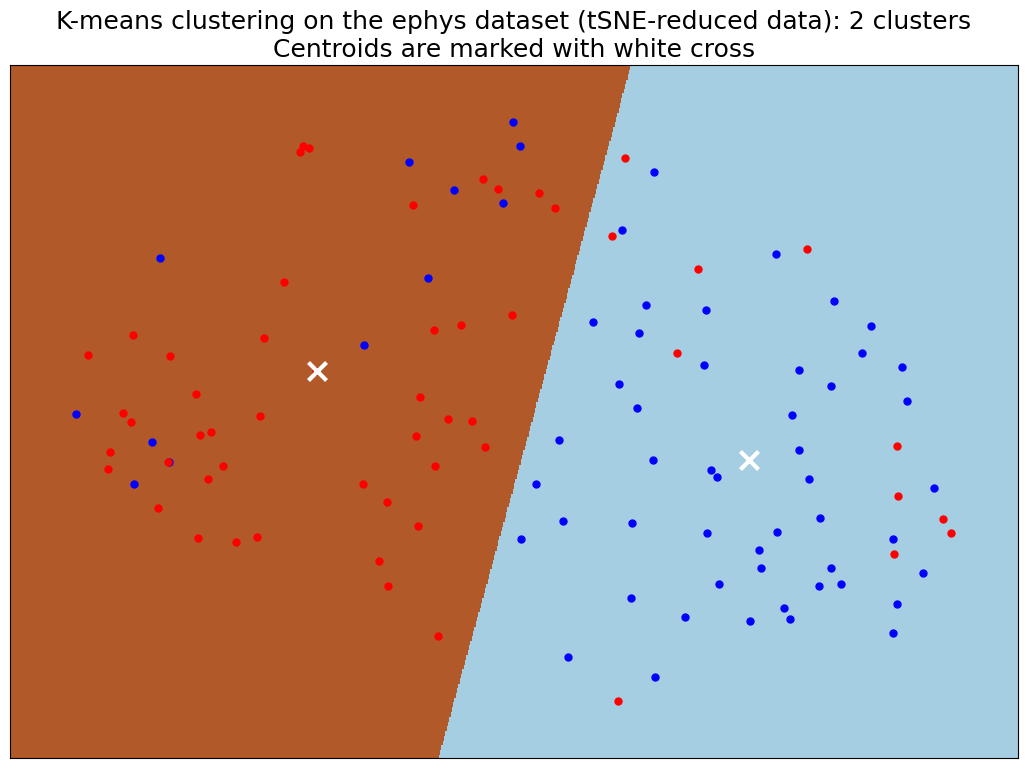

In [152]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_clusters, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_clusters, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_clusters).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


# #############################################################################
# Visualize the results on PCA-reduced data

# no PCA post-processing
#reduced_data = PCA(n_components=2).fit_transform(data)
reduced_data=data

kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()].astype(np.float32))



# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# plot all WG1 
plt.plot(reduced_data[np.where(cell_type_14==1), 0], reduced_data[np.where(cell_type_14==1), 1], 'k.', markersize=10,color='blue')
plt.plot(reduced_data[np.where(cell_type_14==4), 0], reduced_data[np.where(cell_type_14==4), 1], 'k.', markersize=10,color='red')

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the ephys dataset (tSNE-reduced data): 2 clusters\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

#plt.savefig('k_means_tSNE.eps', format='eps', dpi=300)